In [4]:
"""
Data Structure Inspection Script
===============================

This script examines the actual structure of each annotator's JSON file
to understand data inconsistencies causing the NaN/error values.

"""

import json
import pandas as pd
from collections import defaultdict, Counter

# File paths
ANNOTATION_FILES = {
    'Expert_A': r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\alexa_annotations.json',
    'Expert_K': r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\katrin_annotations.json',
    'Expert_L': r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\luisa_annotations.json',
    'Expert_M': r'C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work\martin_annotations.json'
}

# Dimensions we're interested in
SCALED_DIMENSIONS = ['img_simplicity', 'img_quality', 'txt_simplicity', 'txt_quality', 'ethics', 'txt_img_align']

print("="*80)
print("DETAILED DATA STRUCTURE INSPECTION")
print("="*80)

def inspect_annotation_file(filepath, expert_name):
    """
    Thoroughly inspect the structure of one annotation file.
    """
    print(f"\n{'='*60}")
    print(f"INSPECTING {expert_name}")
    print(f"{'='*60}")
    
    with open(filepath, 'r', encoding='utf-8') as f:
        data = json.load(f)
    
    print(f"Total records: {len(data)}")
    
    # Analyze IAA vs non-IAA images
    iaa_images = []
    non_iaa_images = []
    
    # Track dimensions found
    dimensions_found = Counter()
    missing_dimensions = defaultdict(list)
    dimension_values = defaultdict(list)
    
    # Track data inconsistencies
    problematic_records = []
    
    for i, record in enumerate(data):
        # Get image filename
        if 'data' in record and 'original_filename' in record['data']:
            image_filename = record['data']['original_filename']
            
            # Categorize IAA vs non-IAA
            if 'IAA' in image_filename:
                iaa_images.append(image_filename)
            else:
                non_iaa_images.append(image_filename)
            
            # Analyze annotation structure
            if 'annotations' in record and len(record['annotations']) > 0:
                annotation = record['annotations'][0]
                
                if 'result' in annotation:
                    # Track which dimensions are present
                    found_dims = set()
                    
                    for item in annotation['result']:
                        if item['type'] == 'number' and item['from_name'] in SCALED_DIMENSIONS:
                            dimension = item['from_name']
                            found_dims.add(dimension)
                            dimensions_found[dimension] += 1
                            
                            # Get the value
                            value = item['value']['number']
                            dimension_values[dimension].append(value)
                            
                            # Check for problematic values
                            if not isinstance(value, (int, float)):
                                problematic_records.append({
                                    'image': image_filename,
                                    'dimension': dimension,
                                    'value': value,
                                    'type': type(value),
                                    'record_index': i
                                })
                    
                    # Track missing dimensions
                    for expected_dim in SCALED_DIMENSIONS:
                        if expected_dim not in found_dims:
                            missing_dimensions[expected_dim].append(image_filename)
                else:
                    print(f"  WARNING: No 'result' in annotation for {image_filename}")
            else:
                print(f"  WARNING: No annotations for {image_filename}")
    
    # Print summary
    print(f"\nIMAGE BREAKDOWN:")
    print(f"  IAA images: {len(iaa_images)}")
    print(f"  Non-IAA images: {len(non_iaa_images)}")
    print(f"  Total images: {len(iaa_images) + len(non_iaa_images)}")
    
    print(f"\nDIMENSION COVERAGE:")
    for dim in SCALED_DIMENSIONS:
        count = dimensions_found[dim]
        missing_count = len(missing_dimensions[dim])
        print(f"  {dim}: {count} annotations, {missing_count} missing")
    
    print(f"\nVALUE RANGES:")
    for dim in SCALED_DIMENSIONS:
        if dimension_values[dim]:
            values = dimension_values[dim]
            print(f"  {dim}: min={min(values)}, max={max(values)}, count={len(values)}")
            
            # Show value distribution
            value_counts = Counter(values)
            unique_values = sorted(value_counts.keys())
            print(f"    Unique values: {unique_values}")
            
            # Check for out-of-range values
            if dim in ['img_simplicity', 'img_quality', 'txt_simplicity', 'txt_quality']:
                out_of_range = [v for v in values if v < 0 or v > 15]
                if out_of_range:
                    print(f"    ⚠️  OUT OF RANGE (0-15): {set(out_of_range)}")
            elif dim in ['ethics', 'txt_img_align']:
                out_of_range = [v for v in values if v < 0 or v > 20]
                if out_of_range:
                    print(f"    ⚠️  OUT OF RANGE (0-20): {set(out_of_range)}")
    
    print(f"\nPROBLEMATIC RECORDS:")
    if problematic_records:
        for prob in problematic_records[:5]:  # Show first 5
            print(f"  Image: {prob['image']}, Dim: {prob['dimension']}, Value: {prob['value']} (type: {prob['type']})")
        if len(problematic_records) > 5:
            print(f"  ... and {len(problematic_records) - 5} more")
    else:
        print("  ✓ No problematic records found")
    
    return {
        'iaa_images': iaa_images,
        'non_iaa_images': non_iaa_images,
        'dimensions_found': dimensions_found,
        'missing_dimensions': missing_dimensions,
        'dimension_values': dimension_values,
        'problematic_records': problematic_records
    }

# Inspect all files
all_inspections = {}
for expert, filepath in ANNOTATION_FILES.items():
    all_inspections[expert] = inspect_annotation_file(filepath, expert)

print(f"\n{'='*80}")
print("CROSS-EXPERT COMPARISON")
print(f"{'='*80}")

# Compare IAA image coverage
print(f"\nIAA IMAGE COVERAGE COMPARISON:")
for expert, inspection in all_inspections.items():
    iaa_count = len(inspection['iaa_images'])
    print(f"  {expert}: {iaa_count} IAA images")

# Find common IAA images
print(f"\nIAA IMAGE INTERSECTION ANALYSIS:")
iaa_sets = {expert: set(inspection['iaa_images']) for expert, inspection in all_inspections.items()}

# All 4 experts
common_all_4 = set.intersection(*iaa_sets.values())
print(f"  Images annotated by ALL 4 experts: {len(common_all_4)}")

# At least 3 experts
common_3_plus = set()
expert_names = list(iaa_sets.keys())
for i in range(len(expert_names)):
    for j in range(i+1, len(expert_names)):
        for k in range(j+1, len(expert_names)):
            # 3-way intersection
            intersection_3 = iaa_sets[expert_names[i]] & iaa_sets[expert_names[j]] & iaa_sets[expert_names[k]]
            common_3_plus.update(intersection_3)

# Add 4-way intersection
common_3_plus.update(common_all_4)
print(f"  Images annotated by 3+ experts: {len(common_3_plus)}")

# At least 2 experts
common_2_plus = set()
for i in range(len(expert_names)):
    for j in range(i+1, len(expert_names)):
        # 2-way intersection
        intersection_2 = iaa_sets[expert_names[i]] & iaa_sets[expert_names[j]]
        common_2_plus.update(intersection_2)

print(f"  Images annotated by 2+ experts: {len(common_2_plus)}")

# Show some examples
if common_all_4:
    print(f"\nSample images with all 4 experts: {list(common_all_4)[:5]}")

print(f"\n{'='*80}")
print("DIMENSION COMPLETENESS ANALYSIS")
print(f"{'='*80}")

print(f"\nDimension coverage across experts:")
for dim in SCALED_DIMENSIONS:
    print(f"\n{dim}:")
    for expert, inspection in all_inspections.items():
        count = inspection['dimensions_found'][dim]
        total_images = len(inspection['iaa_images']) + len(inspection['non_iaa_images'])
        percentage = (count / total_images * 100) if total_images > 0 else 0
        print(f"  {expert}: {count}/{total_images} ({percentage:.1f}%)")

print(f"\n{'='*80}")
print("RECOMMENDATIONS")
print(f"{'='*80}")

print(f"\nBased on this inspection:")
print(f"1. Check for missing dimension annotations")
print(f"2. Verify value ranges are correct")  
print(f"3. Investigate any problematic data types")
print(f"4. Consider why some experts have more/fewer annotations")
print(f"5. Focus IAA analysis on images with sufficient coverage")

DETAILED DATA STRUCTURE INSPECTION

INSPECTING Expert_A
Total records: 250

IMAGE BREAKDOWN:
  IAA images: 71
  Non-IAA images: 179
  Total images: 250

DIMENSION COVERAGE:
  img_simplicity: 250 annotations, 0 missing
  img_quality: 250 annotations, 0 missing
  txt_simplicity: 250 annotations, 0 missing
  txt_quality: 250 annotations, 0 missing
  ethics: 250 annotations, 0 missing
  txt_img_align: 250 annotations, 0 missing

VALUE RANGES:
  img_simplicity: min=0, max=14, count=250
    Unique values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14]
  img_quality: min=0, max=13, count=250
    Unique values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  txt_simplicity: min=0, max=15, count=250
    Unique values: [0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
  txt_quality: min=2, max=15, count=250
    Unique values: [2, 3, 5, 7, 9, 10, 11, 12, 13, 14, 15]
  ethics: min=0, max=20, count=250
    Unique values: [0, 2, 4, 8, 9, 10, 12, 13, 15, 16, 17, 18, 19, 20]
  txt_img_align: min=0,

In [8]:
"""
Krippendorff's Alpha Inter-Annotator Agreement Analysis
=====================================================

This script analyzes inter-annotator agreement for image accessibility evaluations
using Krippendorff's Alpha, which is more appropriate for subjective ratings than Cohen's Kappa.

Key Features:
- Converts numerical scores to meaningful ordinal categories (Very Low to Very High)
- Handles missing annotations naturally (no imputation needed)
- Analyzes multiple coverage groups (2+, 3+, and 4 expert annotations)
- Provides interpretable reliability coefficients for each evaluation dimension

Author: Thesis Analysis
Date: June 2025
"""

import json
import os
import pandas as pd
import numpy as np
import krippendorff
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FILE PATHS AND CONFIGURATION
# ============================================================================

# Define file paths
ANNOTATION_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work"
MAPPING_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\required files"

# Expert annotation files
ANNOTATION_FILES = {
    'Expert_A': 'alexa_annotations.json',
    'Expert_K': 'katrin_annotations.json', 
    'Expert_L': 'luisa_annotations.json',
    'Expert_M': 'martin_annotations.json'
}

# Mapping file
MAPPING_FILE = 'renamed_images_mapping.csv'

# Define the 6 scaled dimensions we want to analyze
SCALED_DIMENSIONS = {
    # 0-15 scale dimensions
    'img_simplicity': {'scale_max': 15, 'display_name': 'Image Simplicity'},
    'img_quality': {'scale_max': 15, 'display_name': 'Image Quality'},
    'txt_simplicity': {'scale_max': 15, 'display_name': 'Text Simplicity'},
    'txt_quality': {'scale_max': 15, 'display_name': 'Text Quality'},
    # 0-20 scale dimensions
    'ethics': {'scale_max': 20, 'display_name': 'Ethics'},
    'txt_img_align': {'scale_max': 20, 'display_name': 'Text-Image Alignment'}
}

# ============================================================================
# SCALE CONVERSION FUNCTIONS
# ============================================================================

def convert_score_to_category(score, scale_max):
    """
    Convert numerical scores to ordinal categories based on scale range.
    
    Args:
        score (int/float): The numerical score to convert
        scale_max (int): Maximum value of the scale (15 or 20)
    
    Returns:
        int: Ordinal category (0=Very Low, 1=Low, 2=Medium, 3=High, 4=Very High)
        None: If score is missing/invalid
    """
    if score is None or pd.isna(score):
        return None
    
    if scale_max == 15:
        # 0-15 scale mapping
        if 0 <= score <= 3:
            return 0  # Very Low
        elif 4 <= score <= 6:
            return 1  # Low
        elif 7 <= score <= 9:
            return 2  # Medium
        elif 10 <= score <= 12:
            return 3  # High
        elif 13 <= score <= 15:
            return 4  # Very High
    
    elif scale_max == 20:
        # 0-20 scale mapping
        if 0 <= score <= 4:
            return 0  # Very Low
        elif 5 <= score <= 8:
            return 1  # Low
        elif 9 <= score <= 12:
            return 2  # Medium
        elif 13 <= score <= 16:
            return 3  # High
        elif 17 <= score <= 20:
            return 4  # Very High
    
    # Return None for out-of-range scores
    return None

def get_category_name(category_code):
    """
    Convert category code back to human-readable name.
    
    Args:
        category_code (int): Category code (0-4)
    
    Returns:
        str: Human-readable category name
    """
    category_names = {
        0: "Very Low",
        1: "Low", 
        2: "Medium",
        3: "High",
        4: "Very High"
    }
    return category_names.get(category_code, "Unknown")

# ============================================================================
# DATA LOADING AND PROCESSING FUNCTIONS
# ============================================================================

def load_annotation_data():
    """
    Load all expert annotation JSON files.
    
    Returns:
        dict: Dictionary with expert names as keys and annotation data as values
    """
    print("Loading annotation data...")
    print("=" * 50)
    
    expert_data = {}
    
    for expert, filename in ANNOTATION_FILES.items():
        file_path = os.path.join(ANNOTATION_DIR, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            expert_data[expert] = data
            print(f"✓ Loaded {len(data)} annotations for {expert}")
            
        except FileNotFoundError:
            print(f"✗ ERROR: Could not find {filename}")
            return None
        except json.JSONDecodeError:
            print(f"✗ ERROR: Invalid JSON in {filename}")
            return None
    
    print(f"\nTotal experts loaded: {len(expert_data)}")
    return expert_data

def extract_scores_from_annotation(annotation_result):
    """
    Extract numerical scores from Label Studio annotation result.
    
    Args:
        annotation_result (list): The 'result' field from Label Studio annotation
    
    Returns:
        dict: Dictionary with dimension names as keys and scores as values
    """
    scores = {}
    
    # Map Label Studio field names to our standardized names
    field_mapping = {
        'img_simplicity': 'img_simplicity',
        'img_quality': 'img_quality', 
        'txt_simplicity': 'txt_simplicity',
        'txt_quality': 'txt_quality',
        'ethics': 'ethics',
        'txt_img_align': 'txt_img_align'
    }
    
    for item in annotation_result:
        if item.get('type') == 'number':
            from_name = item.get('from_name')
            value = item.get('value', {}).get('number')
            
            # Map to our standardized field names
            if from_name in field_mapping and value is not None:
                scores[field_mapping[from_name]] = value
    
    return scores

def get_iaa_annotations_by_coverage():
    """
    Extract IAA annotations organized by coverage level (2+, 3+, 4 experts).
    
    Returns:
        tuple: (coverage_groups, expert_annotations)
            - coverage_groups: Dict with coverage levels as keys, image sets as values
            - expert_annotations: Dict with expert->image->scores mapping
    """
    print("\nExtracting IAA annotations...")
    print("=" * 50)
    
    # Load expert data
    expert_data = load_annotation_data()
    if expert_data is None:
        return None, None
    
    # Extract IAA annotations for each expert
    expert_annotations = {}
    expert_iaa_images = {}
    
    for expert, data in expert_data.items():
        annotations_dict = {}
        iaa_images = set()
        
        for record in data:
            filename = record['data']['original_filename']
            
            # Only process IAA images (those with '_IAA' in filename)
            if '_IAA' in filename:
                iaa_images.add(filename)
                
                # Extract scores from annotation
                if record['annotations'] and len(record['annotations']) > 0:
                    annotation = record['annotations'][0]['result']
                    scores = extract_scores_from_annotation(annotation)
                    annotations_dict[filename] = scores
        
        expert_annotations[expert] = annotations_dict
        expert_iaa_images[expert] = iaa_images
        
        print(f"  {expert}: {len(iaa_images)} IAA images annotated")
    
    # Find coverage groups
    print("\nAnalyzing coverage patterns...")
    
    # Count how many experts annotated each image
    image_expert_count = defaultdict(list)
    for expert, images in expert_iaa_images.items():
        for image in images:
            image_expert_count[image].append(expert)
    
    # Group images by coverage level
    coverage_groups = {
        '4_experts': set(),
        '3plus_experts': set(),
        '2plus_experts': set()
    }
    
    for image, experts_list in image_expert_count.items():
        coverage = len(experts_list)
        
        if coverage >= 4:
            coverage_groups['4_experts'].add(image)
            coverage_groups['3plus_experts'].add(image)
            coverage_groups['2plus_experts'].add(image)
        elif coverage >= 3:
            coverage_groups['3plus_experts'].add(image)
            coverage_groups['2plus_experts'].add(image)
        elif coverage >= 2:
            coverage_groups['2plus_experts'].add(image)
    
    # Print coverage summary
    print(f"\nCoverage Summary:")
    print(f"  Images with 4 experts: {len(coverage_groups['4_experts'])}")
    print(f"  Images with 3+ experts: {len(coverage_groups['3plus_experts'])}")
    print(f"  Images with 2+ experts: {len(coverage_groups['2plus_experts'])}")
    
    return coverage_groups, expert_annotations

# ============================================================================
# KRIPPENDORFF'S ALPHA CALCULATION FUNCTIONS
# ============================================================================

def prepare_data_for_krippendorff(image_set, expert_annotations, dimension):
    """
    Prepare annotation data in the format required by Krippendorff's Alpha.
    
    Args:
        image_set (set): Set of image filenames to analyze
        expert_annotations (dict): Expert->image->scores mapping
        dimension (str): The dimension to analyze (e.g., 'img_simplicity')
    
    Returns:
        numpy.ndarray: Data matrix in format required by krippendorff package
                      Each row = one annotator, each column = one item (image)
                      Uses np.nan for missing values and int for categories
    """
    experts = ['Expert_A', 'Expert_K', 'Expert_L', 'Expert_M']
    scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
    
    # Sort images for consistent ordering
    sorted_images = sorted(image_set)
    
    # Create data matrix: rows = annotators, columns = items (images)
    data_matrix = []
    
    for expert in experts:
        expert_row = []
        
        for image in sorted_images:
            # Get score for this expert-image combination
            if (expert in expert_annotations and 
                image in expert_annotations[expert] and 
                dimension in expert_annotations[expert][image]):
                
                raw_score = expert_annotations[expert][image][dimension]
                # Convert to ordinal category
                category = convert_score_to_category(raw_score, scale_max)
                
                # Ensure category is a proper integer or missing value
                if category is not None:
                    expert_row.append(int(category))
                else:
                    expert_row.append(np.nan)
            else:
                # Missing annotation - use np.nan
                expert_row.append(np.nan)
        
        data_matrix.append(expert_row)
    
    # Convert to numpy array with float dtype (to handle np.nan)
    data_array = np.array(data_matrix, dtype=float)
    
    return data_array

def calculate_krippendorff_alpha_for_dimension(coverage_groups, expert_annotations, dimension):
    """
    Calculate Krippendorff's Alpha for one dimension across all coverage groups.
    
    Args:
        coverage_groups (dict): Coverage level -> image set mapping
        expert_annotations (dict): Expert->image->scores mapping  
        dimension (str): The dimension to analyze
    
    Returns:
        dict: Results for each coverage group
    """
    results = {}
    display_name = SCALED_DIMENSIONS[dimension]['display_name']
    scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
    
    print(f"\n{'-' * 60}")
    print(f"ANALYZING: {display_name} (0-{scale_max} scale)")
    print(f"{'-' * 60}")
    
    for coverage_level, image_set in coverage_groups.items():
        if len(image_set) == 0:
            print(f"  {coverage_level}: No images available")
            results[coverage_level] = {
                'alpha': None,
                'n_images': 0,
                'n_annotations': 0,
                'interpretation': 'No data'
            }
            continue
        
        # Prepare data matrix
        data_matrix = prepare_data_for_krippendorff(image_set, expert_annotations, dimension)
        
        # Count total annotations (non-NaN values)
        total_annotations = int(np.sum(~np.isnan(data_matrix)))
        
        if total_annotations < 4:  # Need minimum annotations for meaningful alpha
            alpha_value = None
            interpretation = "Insufficient data"
        else:
            try:
                # Calculate Krippendorff's Alpha (ordinal level)
                # The krippendorff package expects missing values as np.nan
                alpha_value = krippendorff.alpha(
                    reliability_data=data_matrix,
                    level_of_measurement='ordinal'
                )
                interpretation = interpret_alpha(alpha_value)
            except Exception as e:
                print(f"    Error calculating alpha: {e}")
                alpha_value = None
                interpretation = "Calculation error"
        
        # Store results
        results[coverage_level] = {
            'alpha': alpha_value,
            'n_images': len(image_set),
            'n_annotations': total_annotations,
            'interpretation': interpretation
        }
        
        # Print results
        if alpha_value is not None:
            print(f"  {coverage_level.replace('_', ' ').title()}: "
                  f"α = {alpha_value:.3f} ({interpretation}) "
                  f"[{len(image_set)} images, {total_annotations} annotations]")
        else:
            print(f"  {coverage_level.replace('_', ' ').title()}: "
                  f"{interpretation} "
                  f"[{len(image_set)} images, {total_annotations} annotations]")
    
    return results

def interpret_alpha(alpha_value):
    """
    Interpret Krippendorff's Alpha values according to standard guidelines.
    
    Args:
        alpha_value (float): The alpha coefficient
    
    Returns:
        str: Interpretation of the alpha value
    """
    if alpha_value is None:
        return "No data"
    elif alpha_value < 0:
        return "Poor (systematic disagreement)"
    elif alpha_value < 0.20:
        return "Poor"
    elif alpha_value < 0.40:
        return "Fair"
    elif alpha_value < 0.60:
        return "Moderate"
    elif alpha_value < 0.80:
        return "Good"
    else:
        return "Excellent"

# ============================================================================
# MAIN ANALYSIS AND REPORTING FUNCTIONS
# ============================================================================

def run_complete_krippendorff_analysis():
    """
    Run the complete Krippendorff's Alpha analysis for all dimensions.
    
    Returns:
        dict: Complete results for all dimensions and coverage levels
    """
    print("=" * 80)
    print("KRIPPENDORFF'S ALPHA INTER-ANNOTATOR AGREEMENT ANALYSIS")
    print("=" * 80)
    print("Converting numerical scores to ordinal categories:")
    print("  0-15 scales: Very Low (0-3), Low (4-6), Medium (7-9), High (10-12), Very High (13-15)")
    print("  0-20 scales: Very Low (0-4), Low (5-8), Medium (9-12), High (13-16), Very High (17-20)")
    
    # Get coverage groups and annotations
    coverage_groups, expert_annotations = get_iaa_annotations_by_coverage()
    if coverage_groups is None:
        print("ERROR: Could not load annotation data")
        return None
    
    # Analyze each dimension
    all_results = {}
    
    for dimension in SCALED_DIMENSIONS.keys():
        dimension_results = calculate_krippendorff_alpha_for_dimension(
            coverage_groups, expert_annotations, dimension
        )
        all_results[dimension] = dimension_results
    
    return all_results, coverage_groups, expert_annotations

def create_summary_table(all_results):
    """
    Create a comprehensive summary table of all Krippendorff's Alpha results.
    
    Args:
        all_results (dict): Complete results from the analysis
    """
    print(f"\n{'=' * 80}")
    print("KRIPPENDORFF'S ALPHA SUMMARY TABLE")
    print(f"{'=' * 80}")
    
    # Create DataFrame for better formatting
    summary_data = []
    
    coverage_levels = ['4_experts', '3plus_experts', '2plus_experts']
    
    for dimension, dimension_results in all_results.items():
        display_name = SCALED_DIMENSIONS[dimension]['display_name']
        scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
        
        for coverage_level in coverage_levels:
            if coverage_level in dimension_results:
                result = dimension_results[coverage_level]
                
                alpha_str = f"{result['alpha']:.3f}" if result['alpha'] is not None else "N/A"
                
                summary_data.append({
                    'Dimension': display_name,
                    'Scale': f"0-{scale_max}",
                    'Coverage': coverage_level.replace('_', ' ').title(),
                    'Alpha': alpha_str,
                    'Interpretation': result['interpretation'],
                    'Images': result['n_images'],
                    'Annotations': result['n_annotations']
                })
    
    # Create and display DataFrame
    df_summary = pd.DataFrame(summary_data)
    print(df_summary.to_string(index=False))
    
    # Calculate overall statistics
    print(f"\n{'=' * 50}")
    print("OVERALL RELIABILITY STATISTICS")
    print(f"{'=' * 50}")
    
    for coverage_level in coverage_levels:
        valid_alphas = []
        
        for dimension_results in all_results.values():
            if coverage_level in dimension_results:
                alpha = dimension_results[coverage_level]['alpha']
                if alpha is not None:
                    valid_alphas.append(alpha)
        
        if valid_alphas:
            mean_alpha = np.mean(valid_alphas)
            std_alpha = np.std(valid_alphas)
            min_alpha = min(valid_alphas)
            max_alpha = max(valid_alphas)
            
            print(f"\n{coverage_level.replace('_', ' ').title()}:")
            print(f"  Mean α: {mean_alpha:.3f} ± {std_alpha:.3f}")
            print(f"  Range: {min_alpha:.3f} to {max_alpha:.3f}")
            print(f"  Interpretation: {interpret_alpha(mean_alpha)}")
            print(f"  Valid dimensions: {len(valid_alphas)}/{len(SCALED_DIMENSIONS)}")

def display_interpretation_guide():
    """Display interpretation guide for Krippendorff's Alpha values."""
    print(f"\n{'=' * 60}")
    print("KRIPPENDORFF'S ALPHA INTERPRETATION GUIDE")
    print(f"{'=' * 60}")
    print("α ≥ 0.80: Excellent reliability")
    print("α ≥ 0.60: Good reliability") 
    print("α ≥ 0.40: Moderate reliability")
    print("α ≥ 0.20: Fair reliability")
    print("α < 0.20: Poor reliability")
    print("α < 0.00: Systematic disagreement")
    print("\nNote: Values ≥ 0.60 are generally considered acceptable for research.")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Run the complete analysis
    print("Starting Krippendorff's Alpha IAA Analysis...")
    
    results = run_complete_krippendorff_analysis()
    
    if results is not None:
        all_results, coverage_groups, expert_annotations = results
        
        # Create summary table
        create_summary_table(all_results)
        
        # Show interpretation guide
        display_interpretation_guide()
        
        print(f"\n{'=' * 80}")
        print("ANALYSIS COMPLETE!")
        print(f"{'=' * 80}")
        print("Results stored in 'all_results' variable")
        print("Coverage groups stored in 'coverage_groups' variable")
        print("Expert annotations stored in 'expert_annotations' variable")
        
        # Store results for further analysis
        krippendorff_results = all_results
        
    else:
        print("Analysis failed. Please check file paths and data format.")

Starting Krippendorff's Alpha IAA Analysis...
KRIPPENDORFF'S ALPHA INTER-ANNOTATOR AGREEMENT ANALYSIS
Converting numerical scores to ordinal categories:
  0-15 scales: Very Low (0-3), Low (4-6), Medium (7-9), High (10-12), Very High (13-15)
  0-20 scales: Very Low (0-4), Low (5-8), Medium (9-12), High (13-16), Very High (17-20)

Extracting IAA annotations...
Loading annotation data...
✓ Loaded 250 annotations for Expert_A
✓ Loaded 250 annotations for Expert_K
✓ Loaded 200 annotations for Expert_L
✓ Loaded 276 annotations for Expert_M

Total experts loaded: 4
  Expert_A: 71 IAA images annotated
  Expert_K: 81 IAA images annotated
  Expert_L: 61 IAA images annotated
  Expert_M: 84 IAA images annotated

Analyzing coverage patterns...

Coverage Summary:
  Images with 4 experts: 19
  Images with 3+ experts: 30
  Images with 2+ experts: 113

------------------------------------------------------------
ANALYZING: Image Simplicity (0-15 scale)
--------------------------------------------------

In [9]:
"""
Enhanced Inter-Annotator Agreement Statistics and Tables
========================================================

This script provides comprehensive statistical analysis and visualization
of Krippendorff's Alpha results across the three coverage categories.

Features:
- Detailed statistics tables for each coverage category
- Comparative analysis across coverage levels
- Visual interpretation and recommendations
- Export-ready tables for thesis inclusion

Author: Thesis Analysis - Enhanced IAA Analysis
Date: June 2025
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# ============================================================================
# ENHANCED STATISTICAL ANALYSIS FUNCTIONS
# ============================================================================

def create_detailed_coverage_analysis(all_results, coverage_groups):
    """
    Create detailed analysis for each coverage category with enhanced statistics.
    
    Args:
        all_results (dict): Results from Krippendorff analysis
        coverage_groups (dict): Coverage categories and their image sets
    
    Returns:
        dict: Enhanced analysis results
    """
    print("=" * 80)
    print("ENHANCED IAA ANALYSIS: DETAILED COVERAGE STATISTICS")
    print("=" * 80)
    
    coverage_analysis = {}
    
    # Define coverage categories with descriptions
    coverage_categories = {
        '4_experts': {
            'name': 'All 4 Experts',
            'description': 'Maximum agreement potential - all experts annotated',
            'n_images': len(coverage_groups['4_experts']),
            'percentage': (len(coverage_groups['4_experts']) / 200) * 100  # out of 200 IAA images
        },
        '3plus_experts': {
            'name': '3+ Experts', 
            'description': 'High coverage - majority expert consensus',
            'n_images': len(coverage_groups['3plus_experts']),
            'percentage': (len(coverage_groups['3plus_experts']) / 200) * 100
        },
        '2plus_experts': {
            'name': '2+ Experts',
            'description': 'Broadest coverage - includes all pairwise comparisons', 
            'n_images': len(coverage_groups['2plus_experts']),
            'percentage': (len(coverage_groups['2plus_experts']) / 200) * 100
        }
    }
    
    # Analyze each coverage category
    for coverage_key, coverage_info in coverage_categories.items():
        print(f"\n{'=' * 60}")
        print(f"CATEGORY: {coverage_info['name'].upper()}")
        print(f"{'=' * 60}")
        print(f"Description: {coverage_info['description']}")
        print(f"Images: {coverage_info['n_images']} ({coverage_info['percentage']:.1f}% of designated IAA set)")
        print(f"Total annotations: {coverage_info['n_images'] * len([k for k in coverage_categories.keys() if k == coverage_key])}")
        
        # Extract alpha values for this coverage category
        alpha_values = []
        dimension_details = []
        
        for dimension, results in all_results.items():
            if coverage_key in results:
                result = results[coverage_key]
                alpha = result['alpha']
                
                dimension_details.append({
                    'Dimension': SCALED_DIMENSIONS[dimension]['display_name'],
                    'Scale': f"0-{SCALED_DIMENSIONS[dimension]['scale_max']}",
                    'Alpha': alpha,
                    'Interpretation': result['interpretation'],
                    'Annotations': result['n_annotations']
                })
                
                if alpha is not None:
                    alpha_values.append(alpha)
        
        # Calculate statistics
        if alpha_values:
            stats = {
                'mean': np.mean(alpha_values),
                'median': np.median(alpha_values),
                'std': np.std(alpha_values),
                'min': np.min(alpha_values),
                'max': np.max(alpha_values),
                'range': np.max(alpha_values) - np.min(alpha_values),
                'valid_dimensions': len(alpha_values),
                'total_dimensions': len(SCALED_DIMENSIONS)
            }
            
            # Count reliability levels
            reliability_counts = {
                'Excellent (≥0.80)': sum(1 for a in alpha_values if a >= 0.80),
                'Good (0.60-0.79)': sum(1 for a in alpha_values if 0.60 <= a < 0.80),
                'Moderate (0.40-0.59)': sum(1 for a in alpha_values if 0.40 <= a < 0.60),
                'Fair (0.20-0.39)': sum(1 for a in alpha_values if 0.20 <= a < 0.40),
                'Poor (<0.20)': sum(1 for a in alpha_values if a < 0.20)
            }
        else:
            stats = None
            reliability_counts = {}
        
        # Store analysis
        coverage_analysis[coverage_key] = {
            'info': coverage_info,
            'dimension_details': dimension_details,
            'statistics': stats,
            'reliability_distribution': reliability_counts,
            'alpha_values': alpha_values
        }
        
        # Print detailed results table
        print(f"\nDETAILED DIMENSION RESULTS:")
        df_dims = pd.DataFrame(dimension_details)
        df_dims['Alpha'] = df_dims['Alpha'].apply(lambda x: f"{x:.3f}" if x is not None else "N/A")
        print(tabulate(df_dims, headers='keys', tablefmt='grid', showindex=False))
        
        # Print statistics
        if stats:
            print(f"\nSTATISTICAL SUMMARY:")
            print(f"  Mean α: {stats['mean']:.3f} ± {stats['std']:.3f}")
            print(f"  Median α: {stats['median']:.3f}")
            print(f"  Range: {stats['min']:.3f} to {stats['max']:.3f} (span: {stats['range']:.3f})")
            print(f"  Valid dimensions: {stats['valid_dimensions']}/{stats['total_dimensions']}")
            print(f"  Overall interpretation: {interpret_alpha(stats['mean'])}")
            
            print(f"\nRELIABILITY DISTRIBUTION:")
            for level, count in reliability_counts.items():
                percentage = (count / len(alpha_values)) * 100 if alpha_values else 0
                print(f"  {level}: {count} dimensions ({percentage:.1f}%)")
        
    return coverage_analysis

def create_comparative_coverage_table(coverage_analysis):
    """
    Create a comparative table across all coverage categories.
    
    Args:
        coverage_analysis (dict): Enhanced analysis results
    
    Returns:
        pd.DataFrame: Comparative table
    """
    print(f"\n{'=' * 80}")
    print("COMPARATIVE ANALYSIS ACROSS COVERAGE CATEGORIES")
    print(f"{'=' * 80}")
    
    # Create comparative statistics table
    comp_data = []
    
    for coverage_key, analysis in coverage_analysis.items():
        info = analysis['info']
        stats = analysis['statistics']
        
        if stats:
            comp_data.append({
                'Coverage Category': info['name'],
                'Images': info['n_images'],
                'Coverage %': f"{info['percentage']:.1f}%",
                'Mean α': f"{stats['mean']:.3f}",
                'Std Dev': f"{stats['std']:.3f}",
                'Range': f"{stats['min']:.3f} - {stats['max']:.3f}",
                'Interpretation': interpret_alpha(stats['mean']),
                'Valid Dims': f"{stats['valid_dimensions']}/{stats['total_dimensions']}"
            })
    
    df_comparative = pd.DataFrame(comp_data)
    print(tabulate(df_comparative, headers='keys', tablefmt='grid', showindex=False))
    
    # Create dimension-wise comparison
    print(f"\n{'=' * 60}")
    print("DIMENSION-WISE COMPARISON ACROSS COVERAGE")
    print(f"{'=' * 60}")
    
    dimension_comparison = []
    
    for dimension in SCALED_DIMENSIONS.keys():
        display_name = SCALED_DIMENSIONS[dimension]['display_name']
        scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
        
        row = {
            'Dimension': display_name,
            'Scale': f"0-{scale_max}"
        }
        
        # Add alpha values for each coverage category
        for coverage_key, analysis in coverage_analysis.items():
            coverage_name = analysis['info']['name']
            
            # Find alpha for this dimension
            alpha_val = None
            for dim_detail in analysis['dimension_details']:
                if dim_detail['Dimension'] == display_name:
                    alpha_val = dim_detail['Alpha']
                    break
            
            row[coverage_name] = alpha_val
        
        dimension_comparison.append(row)
    
    df_dimension = pd.DataFrame(dimension_comparison)
    print(tabulate(df_dimension, headers='keys', tablefmt='grid', showindex=False))
    
    return df_comparative, df_dimension

def create_reliability_insights(coverage_analysis):
    """
    Generate insights and recommendations based on the IAA analysis.
    
    Args:
        coverage_analysis (dict): Enhanced analysis results
    """
    print(f"\n{'=' * 80}")
    print("IAA INSIGHTS AND RECOMMENDATIONS")
    print(f"{'=' * 80}")
    
    # Find best and worst performing dimensions
    all_alphas = {}
    
    for coverage_key, analysis in coverage_analysis.items():
        for dim_detail in analysis['dimension_details']:
            dim_name = dim_detail['Dimension']
            alpha = dim_detail['Alpha']
            
            if alpha != "N/A" and alpha is not None:
                if dim_name not in all_alphas:
                    all_alphas[dim_name] = []
                all_alphas[dim_name].append(float(alpha))
    
    # Calculate average performance per dimension
    dim_averages = {}
    for dim, alphas in all_alphas.items():
        dim_averages[dim] = np.mean(alphas)
    
    # Sort dimensions by performance
    sorted_dims = sorted(dim_averages.items(), key=lambda x: x[1], reverse=True)
    
    print("DIMENSION PERFORMANCE RANKING:")
    print("(Averaged across all coverage categories)")
    print("-" * 50)
    
    for i, (dim, avg_alpha) in enumerate(sorted_dims, 1):
        interpretation = interpret_alpha(avg_alpha)
        print(f"{i}. {dim}: α = {avg_alpha:.3f} ({interpretation})")
    
    # Coverage category recommendations
    print(f"\nCOVERAGE CATEGORY ANALYSIS:")
    print("-" * 40)
    
    for coverage_key, analysis in coverage_analysis.items():
        info = analysis['info']
        stats = analysis['statistics']
        
        if stats:
            print(f"\n{info['name']} ({info['n_images']} images):")
            print(f"  • Mean reliability: {stats['mean']:.3f} ({interpret_alpha(stats['mean'])})")
            print(f"  • Consistency: {stats['std']:.3f} (lower = more consistent)")
            print(f"  • Best dimension: {sorted_dims[0][0]} (α = {max(analysis['alpha_values']):.3f})")
            
            # Recommendations
            if stats['mean'] >= 0.60:
                rec = "✓ Acceptable for research conclusions"
            elif stats['mean'] >= 0.40:
                rec = "⚠ Moderate reliability - interpret with caution"
            elif stats['mean'] >= 0.20:
                rec = "⚠ Fair reliability - limited conclusions possible"
            else:
                rec = "✗ Poor reliability - results should be interpreted carefully"
            
            print(f"  • Recommendation: {rec}")
    
    # Overall insights
    print(f"\nKEY INSIGHTS:")
    print("-" * 20)
    
    best_dim = sorted_dims[0]
    worst_dim = sorted_dims[-1]
    
    print(f"1. Most reliable evaluation: {best_dim[0]} (α = {best_dim[1]:.3f})")
    print(f"2. Most subjective evaluation: {worst_dim[0]} (α = {worst_dim[1]:.3f})")
    
    # Sample size effect
    sample_effects = []
    for coverage_key, analysis in coverage_analysis.items():
        if analysis['statistics']:
            sample_effects.append((
                analysis['info']['n_images'],
                analysis['statistics']['mean']
            ))
    
    sample_effects.sort()
    if len(sample_effects) > 1:
        print(f"3. Sample size effect: {'Positive' if sample_effects[-1][1] > sample_effects[0][1] else 'Negative or mixed'}")
        print(f"   (Smaller sample: α = {sample_effects[0][1]:.3f}, Larger sample: α = {sample_effects[-1][1]:.3f})")
    
    # Systematic disagreement warning
    negative_alphas = []
    for coverage_key, analysis in coverage_analysis.items():
        for alpha in analysis['alpha_values']:
            if alpha < 0:
                negative_alphas.append((coverage_key, alpha))
    
    if negative_alphas:
        print(f"4. ⚠ WARNING: Systematic disagreement detected in {len(negative_alphas)} cases")
        print(f"   This suggests experts have fundamentally different evaluation approaches")

def export_tables_for_thesis(coverage_analysis, df_comparative, df_dimension):
    """
    Export formatted tables suitable for thesis inclusion.
    
    Args:
        coverage_analysis (dict): Enhanced analysis results
        df_comparative (pd.DataFrame): Comparative statistics table
        df_dimension (pd.DataFrame): Dimension-wise comparison table
    """
    print(f"\n{'=' * 80}")
    print("THESIS-READY TABLES")
    print(f"{'=' * 80}")
    
    print("\nTable 1: Inter-Annotator Agreement Summary by Coverage Category")
    print("(Copy-paste ready for thesis)")
    print("-" * 70)
    print(tabulate(df_comparative, headers='keys', tablefmt='latex_booktabs', showindex=False))
    
    print(f"\nTable 2: Krippendorff's Alpha by Dimension and Coverage")
    print("(Copy-paste ready for thesis)")
    print("-" * 70)
    print(tabulate(df_dimension, headers='keys', tablefmt='latex_booktabs', showindex=False))
    
    # Create a summary interpretation table
    summary_data = []
    
    for coverage_key, analysis in coverage_analysis.items():
        if analysis['statistics']:
            stats = analysis['statistics']
            info = analysis['info']
            
            # Count reliability levels
            excellent = sum(1 for a in analysis['alpha_values'] if a >= 0.80)
            good = sum(1 for a in analysis['alpha_values'] if 0.60 <= a < 0.80) 
            moderate = sum(1 for a in analysis['alpha_values'] if 0.40 <= a < 0.60)
            fair = sum(1 for a in analysis['alpha_values'] if 0.20 <= a < 0.40)
            poor = sum(1 for a in analysis['alpha_values'] if a < 0.20)
            
            summary_data.append({
                'Coverage': info['name'],
                'Images': info['n_images'],
                'Mean α': f"{stats['mean']:.3f}",
                'Excellent': excellent,
                'Good': good,
                'Moderate': moderate,
                'Fair': fair,
                'Poor': poor,
                'Overall': interpret_alpha(stats['mean'])
            })
    
    df_summary = pd.DataFrame(summary_data)
    
    print(f"\nTable 3: Reliability Distribution by Coverage Category")
    print("(Copy-paste ready for thesis)")
    print("-" * 70)
    print(tabulate(df_summary, headers='keys', tablefmt='latex_booktabs', showindex=False))

# ============================================================================
# MAIN EXECUTION FUNCTION
# ============================================================================

def run_enhanced_iaa_analysis(all_results, coverage_groups):
    """
    Run the complete enhanced IAA analysis.
    
    Args:
        all_results (dict): Results from Krippendorff analysis
        coverage_groups (dict): Coverage categories and their image sets
    
    Returns:
        dict: Complete enhanced analysis results
    """
    # Ensure we have the SCALED_DIMENSIONS defined
    global SCALED_DIMENSIONS
    SCALED_DIMENSIONS = {
        'img_simplicity': {'scale_max': 15, 'display_name': 'Image Simplicity'},
        'img_quality': {'scale_max': 15, 'display_name': 'Image Quality'},
        'txt_simplicity': {'scale_max': 15, 'display_name': 'Text Simplicity'},
        'txt_quality': {'scale_max': 15, 'display_name': 'Text Quality'},
        'ethics': {'scale_max': 20, 'display_name': 'Ethics'},
        'txt_img_align': {'scale_max': 20, 'display_name': 'Text-Image Alignment'}
    }
    
    def interpret_alpha(alpha_value):
        """Interpret Krippendorff's Alpha values."""
        if alpha_value is None:
            return "No data"
        elif alpha_value < 0:
            return "Poor (systematic disagreement)"
        elif alpha_value < 0.20:
            return "Poor"
        elif alpha_value < 0.40:
            return "Fair"
        elif alpha_value < 0.60:
            return "Moderate"
        elif alpha_value < 0.80:
            return "Good"
        else:
            return "Excellent"
    
    print("Starting Enhanced IAA Statistical Analysis...")
    
    # Step 1: Detailed coverage analysis
    coverage_analysis = create_detailed_coverage_analysis(all_results, coverage_groups)
    
    # Step 2: Comparative analysis
    df_comparative, df_dimension = create_comparative_coverage_table(coverage_analysis)
    
    # Step 3: Insights and recommendations
    create_reliability_insights(coverage_analysis)
    
    # Step 4: Export thesis-ready tables
    export_tables_for_thesis(coverage_analysis, df_comparative, df_dimension)
    
    print(f"\n{'=' * 80}")
    print("ENHANCED IAA ANALYSIS COMPLETE!")
    print(f"{'=' * 80}")
    
    return {
        'coverage_analysis': coverage_analysis,
        'comparative_table': df_comparative,
        'dimension_table': df_dimension
    }

# ============================================================================
# USAGE INSTRUCTIONS
# ============================================================================

if __name__ == "__main__":
    print("Enhanced IAA Statistics Module")
    print("=" * 40)
    print("Usage:")
    print("1. First run the main Krippendorff analysis to get 'all_results' and 'coverage_groups'")
    print("2. Then run: enhanced_results = run_enhanced_iaa_analysis(all_results, coverage_groups)")
    print("3. This will generate detailed statistics, tables, and thesis-ready exports")

Enhanced IAA Statistics Module
Usage:
1. First run the main Krippendorff analysis to get 'all_results' and 'coverage_groups'
2. Then run: enhanced_results = run_enhanced_iaa_analysis(all_results, coverage_groups)
3. This will generate detailed statistics, tables, and thesis-ready exports


In [10]:
# Run the enhanced IAA analysis
enhanced_results = run_enhanced_iaa_analysis(all_results, coverage_groups)

Starting Enhanced IAA Statistical Analysis...
ENHANCED IAA ANALYSIS: DETAILED COVERAGE STATISTICS

CATEGORY: ALL 4 EXPERTS
Description: Maximum agreement potential - all experts annotated
Images: 19 (9.5% of designated IAA set)
Total annotations: 19

DETAILED DIMENSION RESULTS:
+----------------------+---------+---------+------------------+---------------+
| Dimension            | Scale   |   Alpha | Interpretation   |   Annotations |
+======================+=========+=========+==================+===============+
| Image Simplicity     | 0-15    |   0.486 | Moderate         |            76 |
+----------------------+---------+---------+------------------+---------------+
| Image Quality        | 0-15    |   0.013 | Poor             |            76 |
+----------------------+---------+---------+------------------+---------------+
| Text Simplicity      | 0-15    |   0.599 | Moderate         |            76 |
+----------------------+---------+---------+------------------+---------------+
|

Enhanced IAA Statistics Module
Usage:
1. First run the main Krippendorff analysis to get 'all_results' and 'coverage_groups'
2. Then run: enhanced_results = run_enhanced_iaa_analysis(all_results, coverage_groups)
3. Then run: create_krippendorff_visualizations(all_results, coverage_groups)
4. This will generate detailed statistics, tables, and publication-quality visualizations
Starting Enhanced IAA Statistical Analysis...
ENHANCED IAA ANALYSIS: DETAILED COVERAGE STATISTICS

CATEGORY: ALL 4 EXPERTS
Description: Maximum agreement potential - all experts annotated
Images: 19 (9.5% of designated IAA set)
Total annotations: 19

DETAILED DIMENSION RESULTS:
+----------------------+---------+---------+------------------+---------------+
| Dimension            | Scale   |   Alpha | Interpretation   |   Annotations |
+======================+=========+=========+==================+===============+
| Image Simplicity     | 0-15    |   0.486 | Moderate         |            76 |
+-------------------

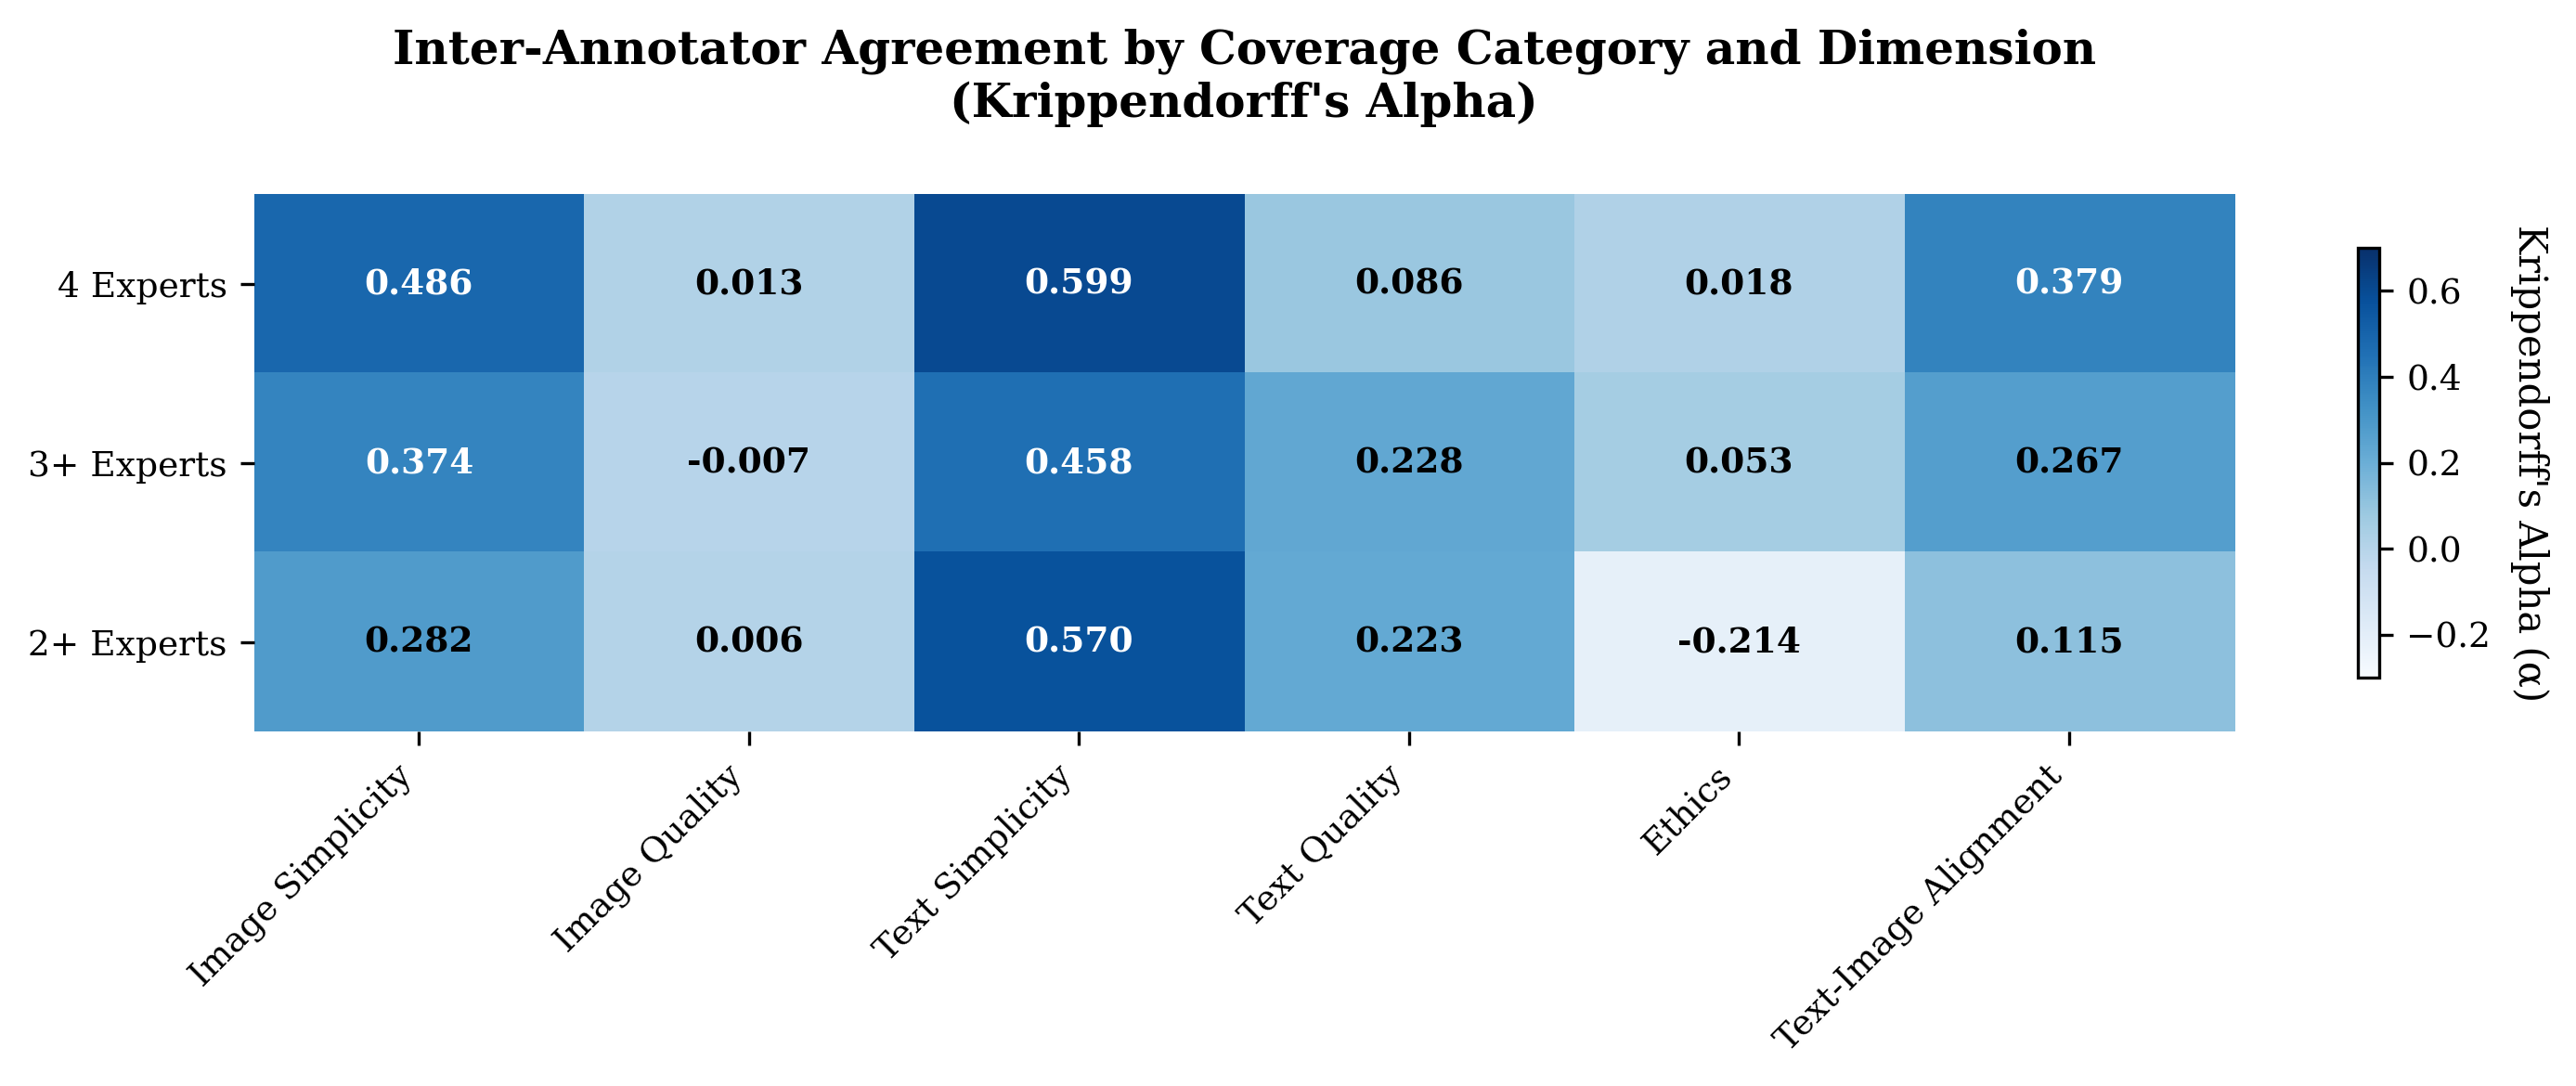

2. Creating grouped bar chart...


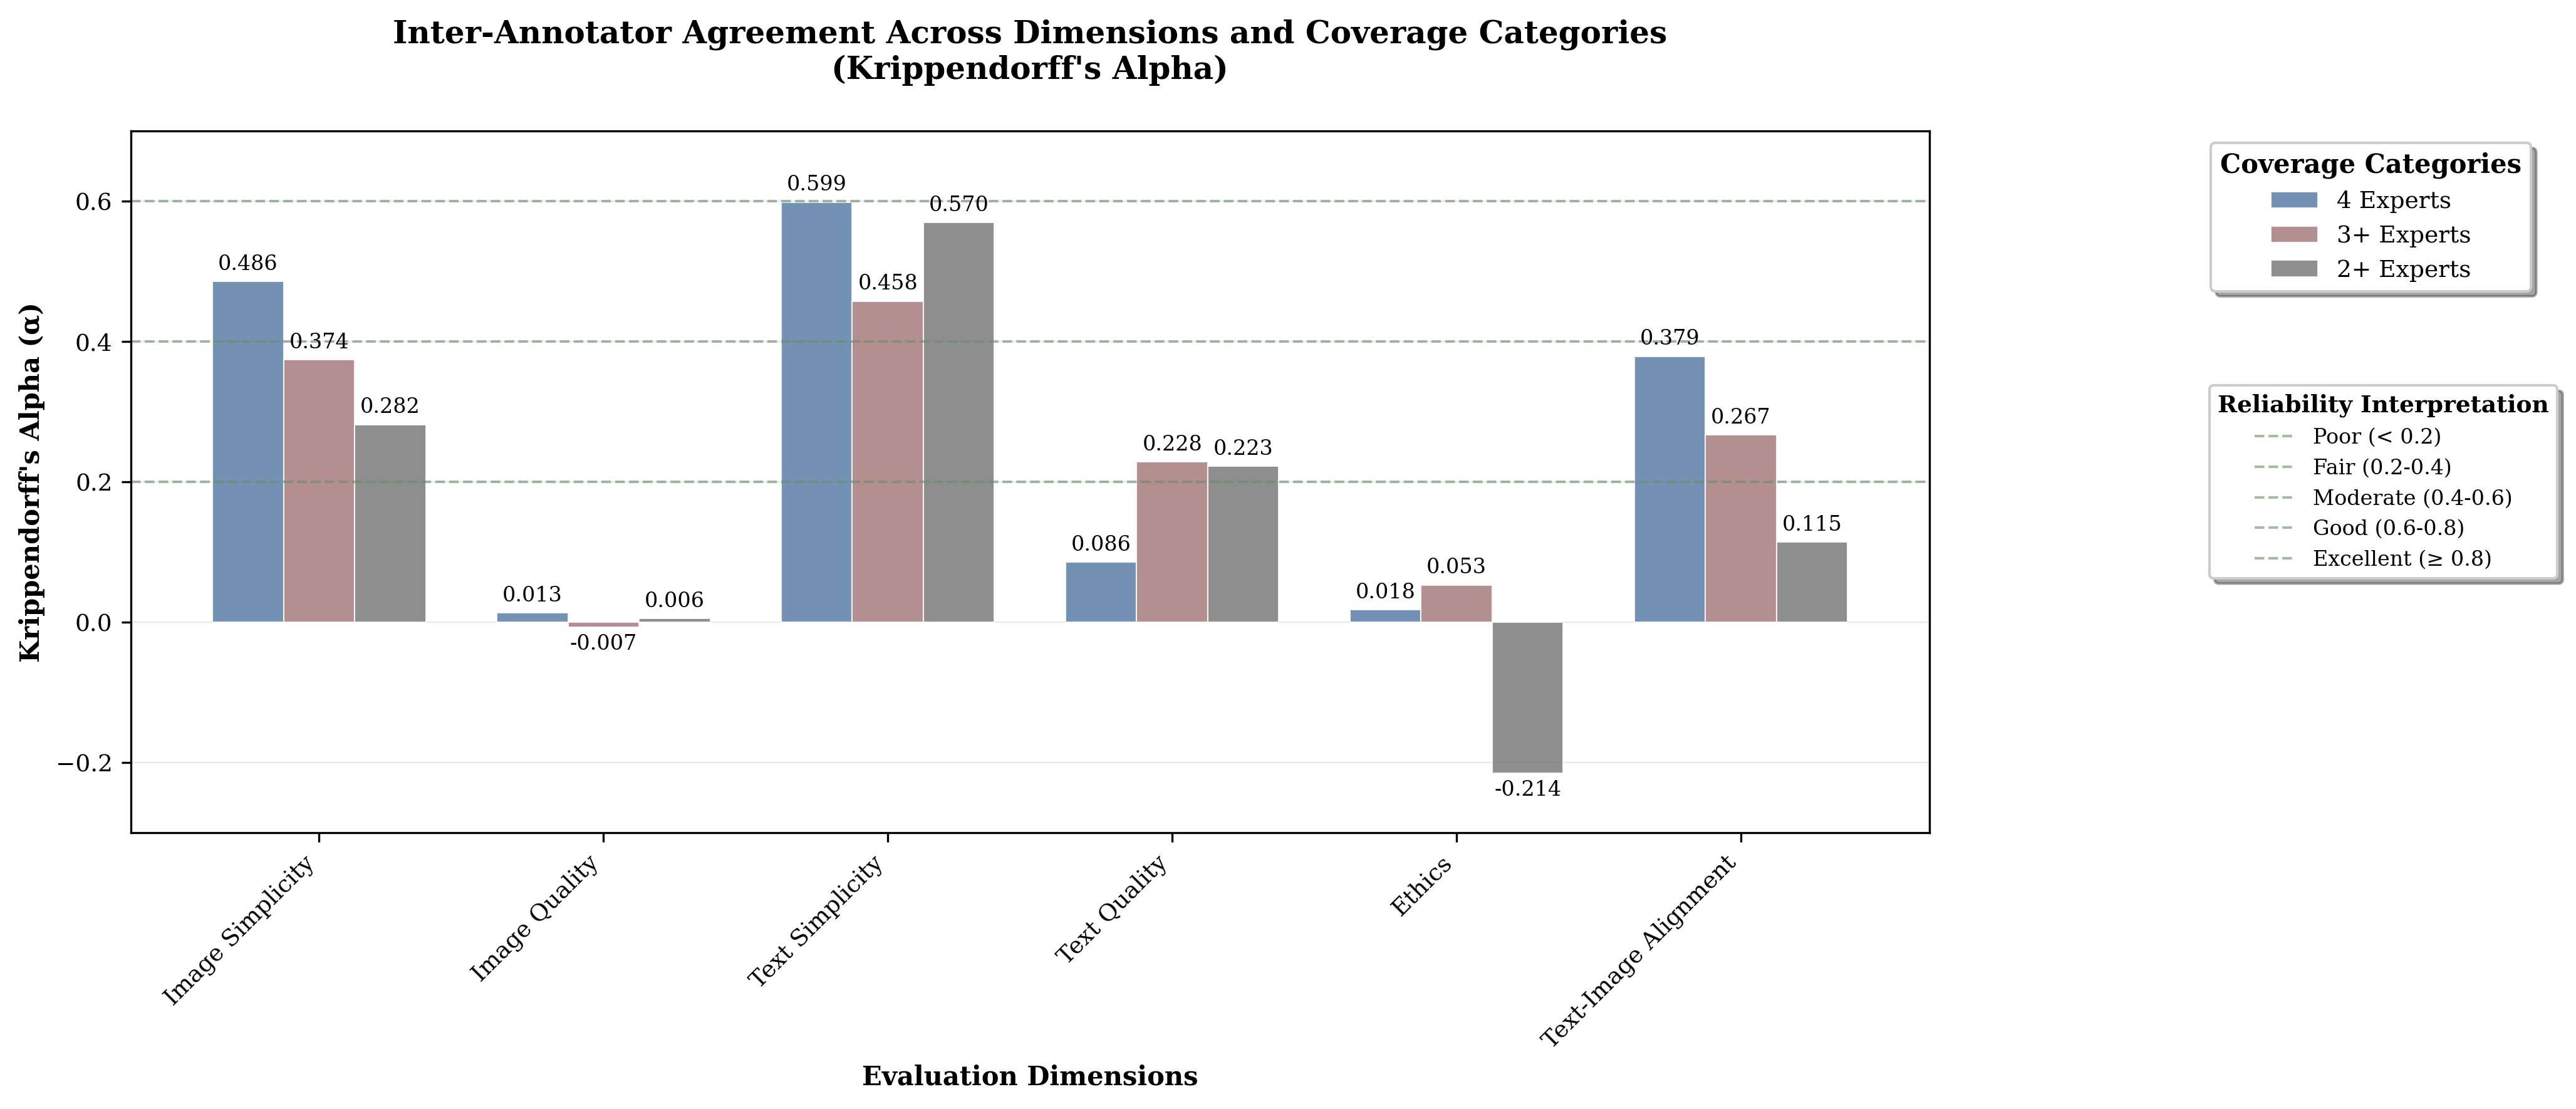

3. Creating summary statistics...


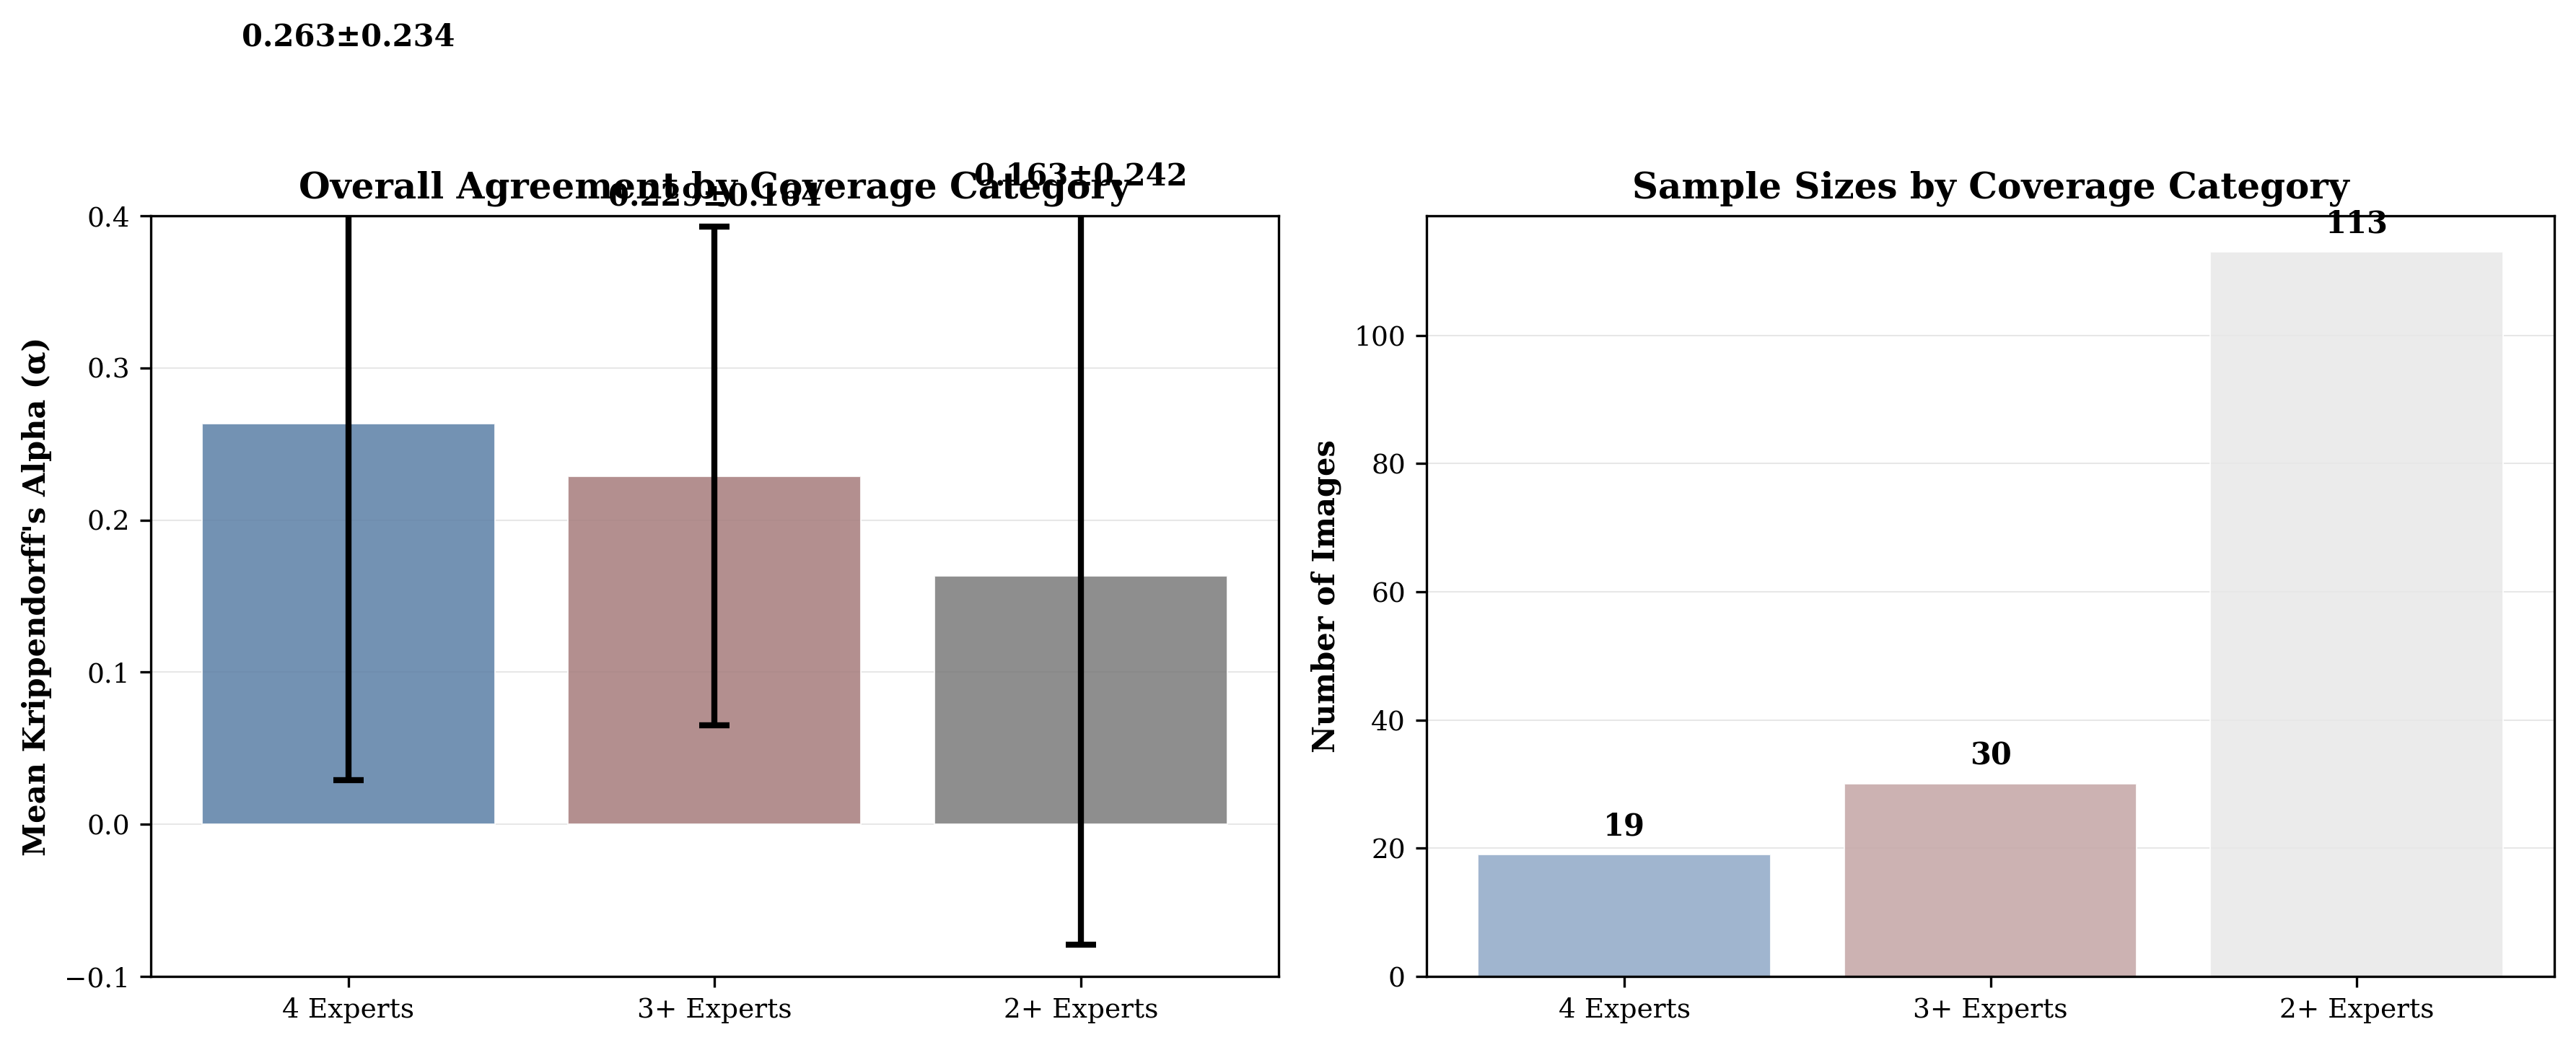

All Krippendorff's Alpha visualizations created successfully!
Files saved with 300 DPI resolution for publication quality.
- krippendorff_heatmap.png
- krippendorff_barchart.png
- krippendorff_summary.png


In [16]:
"""
Enhanced Inter-Annotator Agreement Statistics and Tables
========================================================

This script provides comprehensive statistical analysis and visualization
of Krippendorff's Alpha results across the three coverage categories.

Features:
- Detailed statistics tables for each coverage category
- Comparative analysis across coverage levels
- Visual interpretation and recommendations
- Export-ready tables for thesis inclusion

Author: Thesis Analysis - Enhanced IAA Analysis
Date: June 2025
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_palette("husl")

# ============================================================================
# ENHANCED STATISTICAL ANALYSIS FUNCTIONS
# ============================================================================

def create_detailed_coverage_analysis(all_results, coverage_groups):
    """
    Create detailed analysis for each coverage category with enhanced statistics.
    
    Args:
        all_results (dict): Results from Krippendorff analysis
        coverage_groups (dict): Coverage categories and their image sets
    
    Returns:
        dict: Enhanced analysis results
    """
    print("=" * 80)
    print("ENHANCED IAA ANALYSIS: DETAILED COVERAGE STATISTICS")
    print("=" * 80)
    
    coverage_analysis = {}
    
    # Define coverage categories with descriptions
    coverage_categories = {
        '4_experts': {
            'name': 'All 4 Experts',
            'description': 'Maximum agreement potential - all experts annotated',
            'n_images': len(coverage_groups['4_experts']),
            'percentage': (len(coverage_groups['4_experts']) / 200) * 100  # out of 200 IAA images
        },
        '3plus_experts': {
            'name': '3+ Experts', 
            'description': 'High coverage - majority expert consensus',
            'n_images': len(coverage_groups['3plus_experts']),
            'percentage': (len(coverage_groups['3plus_experts']) / 200) * 100
        },
        '2plus_experts': {
            'name': '2+ Experts',
            'description': 'Broadest coverage - includes all pairwise comparisons', 
            'n_images': len(coverage_groups['2plus_experts']),
            'percentage': (len(coverage_groups['2plus_experts']) / 200) * 100
        }
    }
    
    # Analyze each coverage category
    for coverage_key, coverage_info in coverage_categories.items():
        print(f"\n{'=' * 60}")
        print(f"CATEGORY: {coverage_info['name'].upper()}")
        print(f"{'=' * 60}")
        print(f"Description: {coverage_info['description']}")
        print(f"Images: {coverage_info['n_images']} ({coverage_info['percentage']:.1f}% of designated IAA set)")
        print(f"Total annotations: {coverage_info['n_images'] * len([k for k in coverage_categories.keys() if k == coverage_key])}")
        
        # Extract alpha values for this coverage category
        alpha_values = []
        dimension_details = []
        
        for dimension, results in all_results.items():
            if coverage_key in results:
                result = results[coverage_key]
                alpha = result['alpha']
                
                dimension_details.append({
                    'Dimension': SCALED_DIMENSIONS[dimension]['display_name'],
                    'Scale': f"0-{SCALED_DIMENSIONS[dimension]['scale_max']}",
                    'Alpha': alpha,
                    'Interpretation': result['interpretation'],
                    'Annotations': result['n_annotations']
                })
                
                if alpha is not None:
                    alpha_values.append(alpha)
        
        # Calculate statistics
        if alpha_values:
            stats = {
                'mean': np.mean(alpha_values),
                'median': np.median(alpha_values),
                'std': np.std(alpha_values),
                'min': np.min(alpha_values),
                'max': np.max(alpha_values),
                'range': np.max(alpha_values) - np.min(alpha_values),
                'valid_dimensions': len(alpha_values),
                'total_dimensions': len(SCALED_DIMENSIONS)
            }
            
            # Count reliability levels
            reliability_counts = {
                'Excellent (≥0.80)': sum(1 for a in alpha_values if a >= 0.80),
                'Good (0.60-0.79)': sum(1 for a in alpha_values if 0.60 <= a < 0.80),
                'Moderate (0.40-0.59)': sum(1 for a in alpha_values if 0.40 <= a < 0.60),
                'Fair (0.20-0.39)': sum(1 for a in alpha_values if 0.20 <= a < 0.40),
                'Poor (<0.20)': sum(1 for a in alpha_values if a < 0.20)
            }
        else:
            stats = None
            reliability_counts = {}
        
        # Store analysis
        coverage_analysis[coverage_key] = {
            'info': coverage_info,
            'dimension_details': dimension_details,
            'statistics': stats,
            'reliability_distribution': reliability_counts,
            'alpha_values': alpha_values
        }
        
        # Print detailed results table
        print(f"\nDETAILED DIMENSION RESULTS:")
        df_dims = pd.DataFrame(dimension_details)
        df_dims['Alpha'] = df_dims['Alpha'].apply(lambda x: f"{x:.3f}" if x is not None else "N/A")
        print(tabulate(df_dims, headers='keys', tablefmt='grid', showindex=False))
        
        # Print statistics
        if stats:
            print(f"\nSTATISTICAL SUMMARY:")
            print(f"  Mean α: {stats['mean']:.3f} ± {stats['std']:.3f}")
            print(f"  Median α: {stats['median']:.3f}")
            print(f"  Range: {stats['min']:.3f} to {stats['max']:.3f} (span: {stats['range']:.3f})")
            print(f"  Valid dimensions: {stats['valid_dimensions']}/{stats['total_dimensions']}")
            print(f"  Overall interpretation: {interpret_alpha(stats['mean'])}")
            
            print(f"\nRELIABILITY DISTRIBUTION:")
            for level, count in reliability_counts.items():
                percentage = (count / len(alpha_values)) * 100 if alpha_values else 0
                print(f"  {level}: {count} dimensions ({percentage:.1f}%)")
        
    return coverage_analysis

def create_comparative_coverage_table(coverage_analysis):
    """
    Create a comparative table across all coverage categories.
    
    Args:
        coverage_analysis (dict): Enhanced analysis results
    
    Returns:
        pd.DataFrame: Comparative table
    """
    print(f"\n{'=' * 80}")
    print("COMPARATIVE ANALYSIS ACROSS COVERAGE CATEGORIES")
    print(f"{'=' * 80}")
    
    # Create comparative statistics table
    comp_data = []
    
    for coverage_key, analysis in coverage_analysis.items():
        info = analysis['info']
        stats = analysis['statistics']
        
        if stats:
            comp_data.append({
                'Coverage Category': info['name'],
                'Images': info['n_images'],
                'Coverage %': f"{info['percentage']:.1f}%",
                'Mean α': f"{stats['mean']:.3f}",
                'Std Dev': f"{stats['std']:.3f}",
                'Range': f"{stats['min']:.3f} - {stats['max']:.3f}",
                'Interpretation': interpret_alpha(stats['mean']),
                'Valid Dims': f"{stats['valid_dimensions']}/{stats['total_dimensions']}"
            })
    
    df_comparative = pd.DataFrame(comp_data)
    print(tabulate(df_comparative, headers='keys', tablefmt='grid', showindex=False))
    
    # Create dimension-wise comparison
    print(f"\n{'=' * 60}")
    print("DIMENSION-WISE COMPARISON ACROSS COVERAGE")
    print(f"{'=' * 60}")
    
    dimension_comparison = []
    
    for dimension in SCALED_DIMENSIONS.keys():
        display_name = SCALED_DIMENSIONS[dimension]['display_name']
        scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
        
        row = {
            'Dimension': display_name,
            'Scale': f"0-{scale_max}"
        }
        
        # Add alpha values for each coverage category
        for coverage_key, analysis in coverage_analysis.items():
            coverage_name = analysis['info']['name']
            
            # Find alpha for this dimension
            alpha_val = None
            for dim_detail in analysis['dimension_details']:
                if dim_detail['Dimension'] == display_name:
                    alpha_val = dim_detail['Alpha']
                    break
            
            row[coverage_name] = alpha_val
        
        dimension_comparison.append(row)
    
    df_dimension = pd.DataFrame(dimension_comparison)
    print(tabulate(df_dimension, headers='keys', tablefmt='grid', showindex=False))
    
    return df_comparative, df_dimension

def create_reliability_insights(coverage_analysis):
    """
    Generate insights and recommendations based on the IAA analysis.
    
    Args:
        coverage_analysis (dict): Enhanced analysis results
    """
    print(f"\n{'=' * 80}")
    print("IAA INSIGHTS AND RECOMMENDATIONS")
    print(f"{'=' * 80}")
    
    # Find best and worst performing dimensions
    all_alphas = {}
    
    for coverage_key, analysis in coverage_analysis.items():
        for dim_detail in analysis['dimension_details']:
            dim_name = dim_detail['Dimension']
            alpha = dim_detail['Alpha']
            
            if alpha != "N/A" and alpha is not None:
                if dim_name not in all_alphas:
                    all_alphas[dim_name] = []
                all_alphas[dim_name].append(float(alpha))
    
    # Calculate average performance per dimension
    dim_averages = {}
    for dim, alphas in all_alphas.items():
        dim_averages[dim] = np.mean(alphas)
    
    # Sort dimensions by performance
    sorted_dims = sorted(dim_averages.items(), key=lambda x: x[1], reverse=True)
    
    print("DIMENSION PERFORMANCE RANKING:")
    print("(Averaged across all coverage categories)")
    print("-" * 50)
    
    for i, (dim, avg_alpha) in enumerate(sorted_dims, 1):
        interpretation = interpret_alpha(avg_alpha)
        print(f"{i}. {dim}: α = {avg_alpha:.3f} ({interpretation})")
    
    # Coverage category recommendations
    print(f"\nCOVERAGE CATEGORY ANALYSIS:")
    print("-" * 40)
    
    for coverage_key, analysis in coverage_analysis.items():
        info = analysis['info']
        stats = analysis['statistics']
        
        if stats:
            print(f"\n{info['name']} ({info['n_images']} images):")
            print(f"  • Mean reliability: {stats['mean']:.3f} ({interpret_alpha(stats['mean'])})")
            print(f"  • Consistency: {stats['std']:.3f} (lower = more consistent)")
            print(f"  • Best dimension: {sorted_dims[0][0]} (α = {max(analysis['alpha_values']):.3f})")
            
            # Recommendations
            if stats['mean'] >= 0.60:
                rec = "✓ Acceptable for research conclusions"
            elif stats['mean'] >= 0.40:
                rec = "⚠ Moderate reliability - interpret with caution"
            elif stats['mean'] >= 0.20:
                rec = "⚠ Fair reliability - limited conclusions possible"
            else:
                rec = "✗ Poor reliability - results should be interpreted carefully"
            
            print(f"  • Recommendation: {rec}")
    
    # Overall insights
    print(f"\nKEY INSIGHTS:")
    print("-" * 20)
    
    best_dim = sorted_dims[0]
    worst_dim = sorted_dims[-1]
    
    print(f"1. Most reliable evaluation: {best_dim[0]} (α = {best_dim[1]:.3f})")
    print(f"2. Most subjective evaluation: {worst_dim[0]} (α = {worst_dim[1]:.3f})")
    
    # Sample size effect
    sample_effects = []
    for coverage_key, analysis in coverage_analysis.items():
        if analysis['statistics']:
            sample_effects.append((
                analysis['info']['n_images'],
                analysis['statistics']['mean']
            ))
    
    sample_effects.sort()
    if len(sample_effects) > 1:
        print(f"3. Sample size effect: {'Positive' if sample_effects[-1][1] > sample_effects[0][1] else 'Negative or mixed'}")
        print(f"   (Smaller sample: α = {sample_effects[0][1]:.3f}, Larger sample: α = {sample_effects[-1][1]:.3f})")
    
    # Systematic disagreement warning
    negative_alphas = []
    for coverage_key, analysis in coverage_analysis.items():
        for alpha in analysis['alpha_values']:
            if alpha < 0:
                negative_alphas.append((coverage_key, alpha))
    
    if negative_alphas:
        print(f"4. ⚠ WARNING: Systematic disagreement detected in {len(negative_alphas)} cases")
        print(f"   This suggests experts have fundamentally different evaluation approaches")

def export_tables_for_thesis(coverage_analysis, df_comparative, df_dimension):
    """
    Export formatted tables suitable for thesis inclusion.
    
    Args:
        coverage_analysis (dict): Enhanced analysis results
        df_comparative (pd.DataFrame): Comparative statistics table
        df_dimension (pd.DataFrame): Dimension-wise comparison table
    """
    print(f"\n{'=' * 80}")
    print("THESIS-READY TABLES")
    print(f"{'=' * 80}")
    
    print("\nTable 1: Inter-Annotator Agreement Summary by Coverage Category")
    print("(Copy-paste ready for thesis)")
    print("-" * 70)
    print(tabulate(df_comparative, headers='keys', tablefmt='latex_booktabs', showindex=False))
    
    print(f"\nTable 2: Krippendorff's Alpha by Dimension and Coverage")
    print("(Copy-paste ready for thesis)")
    print("-" * 70)
    print(tabulate(df_dimension, headers='keys', tablefmt='latex_booktabs', showindex=False))
    
    # Create a summary interpretation table
    summary_data = []
    
    for coverage_key, analysis in coverage_analysis.items():
        if analysis['statistics']:
            stats = analysis['statistics']
            info = analysis['info']
            
            # Count reliability levels
            excellent = sum(1 for a in analysis['alpha_values'] if a >= 0.80)
            good = sum(1 for a in analysis['alpha_values'] if 0.60 <= a < 0.80) 
            moderate = sum(1 for a in analysis['alpha_values'] if 0.40 <= a < 0.60)
            fair = sum(1 for a in analysis['alpha_values'] if 0.20 <= a < 0.40)
            poor = sum(1 for a in analysis['alpha_values'] if a < 0.20)
            
            summary_data.append({
                'Coverage': info['name'],
                'Images': info['n_images'],
                'Mean α': f"{stats['mean']:.3f}",
                'Excellent': excellent,
                'Good': good,
                'Moderate': moderate,
                'Fair': fair,
                'Poor': poor,
                'Overall': interpret_alpha(stats['mean'])
            })
    
    df_summary = pd.DataFrame(summary_data)
    
    print(f"\nTable 3: Reliability Distribution by Coverage Category")
    print("(Copy-paste ready for thesis)")
    print("-" * 70)
    print(tabulate(df_summary, headers='keys', tablefmt='latex_booktabs', showindex=False))

# ============================================================================
# MAIN EXECUTION FUNCTION
# ============================================================================

def run_enhanced_iaa_analysis(all_results, coverage_groups):
    """
    Run the complete enhanced IAA analysis.
    
    Args:
        all_results (dict): Results from Krippendorff analysis
        coverage_groups (dict): Coverage categories and their image sets
    
    Returns:
        dict: Complete enhanced analysis results
    """
    # Ensure we have the SCALED_DIMENSIONS defined
    global SCALED_DIMENSIONS
    SCALED_DIMENSIONS = {
        'img_simplicity': {'scale_max': 15, 'display_name': 'Image Simplicity'},
        'img_quality': {'scale_max': 15, 'display_name': 'Image Quality'},
        'txt_simplicity': {'scale_max': 15, 'display_name': 'Text Simplicity'},
        'txt_quality': {'scale_max': 15, 'display_name': 'Text Quality'},
        'ethics': {'scale_max': 20, 'display_name': 'Ethics'},
        'txt_img_align': {'scale_max': 20, 'display_name': 'Text-Image Alignment'}
    }
    
    def interpret_alpha(alpha_value):
        """Interpret Krippendorff's Alpha values."""
        if alpha_value is None:
            return "No data"
        elif alpha_value < 0:
            return "Poor (systematic disagreement)"
        elif alpha_value < 0.20:
            return "Poor"
        elif alpha_value < 0.40:
            return "Fair"
        elif alpha_value < 0.60:
            return "Moderate"
        elif alpha_value < 0.80:
            return "Good"
        else:
            return "Excellent"
    
    print("Starting Enhanced IAA Statistical Analysis...")
    
    # Step 1: Detailed coverage analysis
    coverage_analysis = create_detailed_coverage_analysis(all_results, coverage_groups)
    
    # Step 2: Comparative analysis
    df_comparative, df_dimension = create_comparative_coverage_table(coverage_analysis)
    
    # Step 3: Insights and recommendations
    create_reliability_insights(coverage_analysis)
    
    # Step 4: Export thesis-ready tables
    export_tables_for_thesis(coverage_analysis, df_comparative, df_dimension)
    
    print(f"\n{'=' * 80}")
    print("ENHANCED IAA ANALYSIS COMPLETE!")
    print(f"{'=' * 80}")
    
    return {
        'coverage_analysis': coverage_analysis,
        'comparative_table': df_comparative,
        'dimension_table': df_dimension
    }

# ============================================================================
# VISUALIZATION FUNCTIONS - MATCHING YOUR COLOR SCHEME
# ============================================================================

def create_krippendorff_visualizations(all_results, coverage_groups):
    """
    Create publication-quality visualizations matching your color scheme.
    
    Args:
        all_results (dict): Results from Krippendorff analysis
        coverage_groups (dict): Coverage categories and their image sets
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    # Set style parameters for publication-quality figures (matching your style)
    plt.rcParams.update({
        'figure.dpi': 300,
        'savefig.dpi': 300,
        'font.size': 10,
        'axes.titlesize': 12,
        'axes.labelsize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        'figure.titlesize': 14,
        'font.family': 'serif',
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0
    })
    
    # Define elegant, muted color scheme (matching your plots)
    colors = {
        'primary_blue': '#5B7FA6',      # Muted steel blue
        'primary_red': '#A67C7C',       # Muted dusty rose  
        'light_blue': '#8FA8C7',        # Light muted blue
        'light_red': '#C4A5A5',         # Light muted rose
        'dark_blue': '#4A6B8A',         # Dark muted blue
        'dark_red': '#8B6B6B',          # Dark muted rose
        'gray': '#7A7A7A',              # Professional gray
        'light_gray': '#E8E8E8',        # Very light gray
        'accent': '#6B8E6B',            # Muted sage green
        'neutral': '#9B9B9B'            # Neutral medium gray
    }
    
    # Prepare data for visualization
    coverage_categories = ['4_experts', '3plus_experts', '2plus_experts']
    coverage_names = ['4 Experts', '3+ Experts', '2+ Experts']
    dimension_names = [SCALED_DIMENSIONS[dim]['display_name'] for dim in SCALED_DIMENSIONS.keys()]
    
    # Extract alpha values into matrix format
    alpha_matrix = []
    for coverage in coverage_categories:
        row = []
        for dimension in SCALED_DIMENSIONS.keys():
            if coverage in all_results[dimension]:
                alpha = all_results[dimension][coverage]['alpha']
                row.append(alpha if alpha is not None else 0)
            else:
                row.append(0)
        alpha_matrix.append(row)
    
    alpha_df = pd.DataFrame(alpha_matrix, 
                           index=coverage_names,
                           columns=dimension_names)
    
    print(f"\n{'=' * 60}")
    print("CREATING KRIPPENDORFF'S ALPHA VISUALIZATIONS")
    print(f"{'=' * 60}")
    
    # 1. Create elegant heatmap
    print("1. Creating Krippendorff's Alpha heatmap...")
    fig, ax = plt.subplots(figsize=(10, 4))
    
    # Use Blues colormap (elegant and professional)
    cmap = plt.cm.Blues
    im = ax.imshow(alpha_df.values, cmap=cmap, aspect='auto', vmin=-0.3, vmax=0.7)
    
    # Set ticks and labels
    ax.set_xticks(range(len(alpha_df.columns)))
    ax.set_yticks(range(len(alpha_df.index)))
    ax.set_xticklabels(alpha_df.columns, rotation=45, ha='right')
    ax.set_yticklabels(alpha_df.index)
    
    # Add value annotations with better contrast
    for i in range(len(alpha_df.index)):
        for j in range(len(alpha_df.columns)):
            value = alpha_df.iloc[i, j]
            ax.text(j, i, f'{value:.3f}', ha='center', va='center', 
                   color='white' if value > 0.3 else 'black', fontweight='bold', fontsize=9)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Krippendorff\'s Alpha (α)', rotation=270, labelpad=15)
    
    # Add title and improve layout
    ax.set_title('Inter-Annotator Agreement by Coverage Category and Dimension\n(Krippendorff\'s Alpha)', 
                fontweight='bold', pad=20)
    
    # Remove spines
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.savefig('krippendorff_heatmap.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # 2. Create grouped bar chart
    print("2. Creating grouped bar chart...")
    x = np.arange(len(dimension_names))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Create bars for each category with your elegant muted colors
    bars1 = ax.bar(x - width, alpha_df.iloc[0], width, 
                   label='4 Experts', color=colors['primary_blue'], alpha=0.85, 
                   edgecolor='white', linewidth=0.5)
    bars2 = ax.bar(x, alpha_df.iloc[1], width, 
                   label='3+ Experts', color=colors['primary_red'], alpha=0.85, 
                   edgecolor='white', linewidth=0.5)
    bars3 = ax.bar(x + width, alpha_df.iloc[2], width, 
                   label='2+ Experts', color=colors['gray'], alpha=0.85, 
                   edgecolor='white', linewidth=0.5)
    
    # Customize the plot
    ax.set_xlabel('Evaluation Dimensions', fontweight='bold')
    ax.set_ylabel('Krippendorff\'s Alpha (α)', fontweight='bold')
    ax.set_title('Inter-Annotator Agreement Across Dimensions and Coverage Categories\n(Krippendorff\'s Alpha)', 
                fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(dimension_names, rotation=45, ha='right')
    
    # Add interpretation reference lines (keep the dashes)
    ax.axhline(y=0.2, color=colors['accent'], linestyle='--', alpha=0.6, linewidth=1)
    ax.axhline(y=0.4, color=colors['accent'], linestyle='--', alpha=0.6, linewidth=1)
    ax.axhline(y=0.6, color=colors['accent'], linestyle='--', alpha=0.6, linewidth=1)
    ax.axhline(y=0.8, color=colors['accent'], linestyle='--', alpha=0.6, linewidth=1)
    
    # Create interpretation legend (instead of cluttering the plot)
    interpretation_lines = [
        plt.Line2D([0], [0], color=colors['accent'], linestyle='--', alpha=0.6, label='Poor (< 0.2)'),
        plt.Line2D([0], [0], color=colors['accent'], linestyle='--', alpha=0.6, label='Fair (0.2-0.4)'),
        plt.Line2D([0], [0], color=colors['accent'], linestyle='--', alpha=0.6, label='Moderate (0.4-0.6)'),
        plt.Line2D([0], [0], color=colors['accent'], linestyle='--', alpha=0.6, label='Good (0.6-0.8)'),
        plt.Line2D([0], [0], color=colors['accent'], linestyle='--', alpha=0.6, label='Excellent (≥ 0.8)')
    ]
    
    # Add value labels on bars
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            if height >= 0:
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)
            else:
                ax.text(bar.get_x() + bar.get_width()/2., height - 0.01,
                       f'{height:.3f}', ha='center', va='top', fontsize=8)
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    add_value_labels(bars3)
    
    # Create two separate legends positioned to avoid blocking data
    # Legend 1: Coverage categories (upper right, outside plot area)
    coverage_legend = ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', 
                               frameon=True, fancybox=True, shadow=True, title='Coverage Categories')
    coverage_legend.get_title().set_fontweight('bold')
    
    # Legend 2: Interpretation guide (lower right, outside plot area)
    interpretation_legend = ax.legend(handles=interpretation_lines, bbox_to_anchor=(1.15, 0.5), 
                                    loc='center left', frameon=True, fancybox=True, shadow=True, 
                                    title='Reliability Interpretation', fontsize=8)
    interpretation_legend.get_title().set_fontweight('bold')
    interpretation_legend.get_title().set_fontsize(9)
    
    # Add the coverage legend back (matplotlib removes the first one when adding second)
    ax.add_artist(coverage_legend)
    
    # Set grid
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_axisbelow(True)
    
    # Set y-axis limits to accommodate negative values
    ax.set_ylim(-0.3, 0.7)
    
    plt.tight_layout()
    plt.savefig('krippendorff_barchart.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    # 3. Create summary statistics plot
    print("3. Creating summary statistics...")
    
    # Calculate statistics for each coverage category
    categories = coverage_names
    means = []
    stds = []
    sample_sizes = [len(coverage_groups[cat]) for cat in coverage_categories]
    
    for coverage in coverage_categories:
        alphas = []
        for dimension in SCALED_DIMENSIONS.keys():
            if coverage in all_results[dimension]:
                alpha = all_results[dimension][coverage]['alpha']
                if alpha is not None:
                    alphas.append(alpha)
        
        if alphas:
            means.append(np.mean(alphas))
            stds.append(np.std(alphas))
        else:
            means.append(0)
            stds.append(0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot 1: Mean alpha with error bars
    bars1 = ax1.bar(categories, means, yerr=stds, capsize=5,
                    color=[colors['primary_blue'], colors['primary_red'], colors['gray']], 
                    alpha=0.85, error_kw={'linewidth': 2, 'capthick': 2}, 
                    edgecolor='white', linewidth=0.5)
    
    ax1.set_title('Overall Agreement by Coverage Category', fontweight='bold')
    ax1.set_ylabel('Mean Krippendorff\'s Alpha (α)', fontweight='bold')
    ax1.set_ylim(-0.1, 0.4)
    
    # Add value labels
    for bar, mean, std in zip(bars1, means, stds):
        ax1.text(bar.get_x() + bar.get_width()/2., mean + std + 0.01,
                f'{mean:.3f}±{std:.3f}', ha='center', va='bottom', fontweight='bold')
    
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_axisbelow(True)
    
    # Plot 2: Sample sizes
    bars2 = ax2.bar(categories, sample_sizes,
                    color=[colors['light_blue'], colors['light_red'], colors['light_gray']], 
                    alpha=0.85, edgecolor='white', linewidth=0.5)
    
    ax2.set_title('Sample Sizes by Coverage Category', fontweight='bold')
    ax2.set_ylabel('Number of Images', fontweight='bold')
    
    # Add value labels
    for bar, size in zip(bars2, sample_sizes):
        ax2.text(bar.get_x() + bar.get_width()/2., size + 2,
                f'{size}', ha='center', va='bottom', fontweight='bold')
    
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_axisbelow(True)
    
    plt.tight_layout()
    plt.savefig('krippendorff_summary.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    print("=" * 60)
    print("All Krippendorff's Alpha visualizations created successfully!")
    print("Files saved with 300 DPI resolution for publication quality.")
    print("- krippendorff_heatmap.png")
    print("- krippendorff_barchart.png") 
    print("- krippendorff_summary.png")

# ============================================================================
# USAGE INSTRUCTIONS
# ============================================================================

if __name__ == "__main__":
    print("Enhanced IAA Statistics Module")
    print("=" * 40)
    print("Usage:")
    print("1. First run the main Krippendorff analysis to get 'all_results' and 'coverage_groups'")
    print("2. Then run: enhanced_results = run_enhanced_iaa_analysis(all_results, coverage_groups)")
    print("3. Then run: create_krippendorff_visualizations(all_results, coverage_groups)")
    print("4. This will generate detailed statistics, tables, and publication-quality visualizations")

# Step 1: Run the enhanced statistical analysis
enhanced_results = run_enhanced_iaa_analysis(all_results, coverage_groups)

# Step 2: Create the publication-quality visualizations  
create_krippendorff_visualizations(all_results, coverage_groups)

In [22]:
"""
Inter-Annotator Agreement Analysis by Image Style
================================================

This script analyzes IAA using Krippendorff's Alpha across different image styles
for each of the three coverage categories (4 experts, 3+ experts, 2+ experts).

Features:
- Maps original filenames to image styles using the mapping CSV
- Calculates Krippendorff's Alpha for each style within each coverage category
- Provides comprehensive tables and analysis by style
- Identifies which styles show better/worse expert agreement

Author: Thesis Analysis - Style-Based IAA
Date: June 2025
"""

import pandas as pd
import numpy as np
import krippendorff
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# CONFIGURATION AND FILE PATHS
# ============================================================================

# File paths (update these to match your setup)
MAPPING_FILE_PATH = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\required files\renamed_images_mapping.csv"

# Define the 6 scaled dimensions we're analyzing
SCALED_DIMENSIONS = {
    'img_simplicity': {'scale_max': 15, 'display_name': 'Image Simplicity'},
    'img_quality': {'scale_max': 15, 'display_name': 'Image Quality'},
    'txt_simplicity': {'scale_max': 15, 'display_name': 'Text Simplicity'},
    'txt_quality': {'scale_max': 15, 'display_name': 'Text Quality'},
    'ethics': {'scale_max': 20, 'display_name': 'Ethics'},
    'txt_img_align': {'scale_max': 20, 'display_name': 'Text-Image Alignment'}
}

# ============================================================================
# UTILITY FUNCTIONS FROM PREVIOUS ANALYSIS
# ============================================================================

def convert_score_to_category(score, scale_max):
    """Convert numerical scores to ordinal categories."""
    if score is None or pd.isna(score):
        return None
    
    if scale_max == 15:
        if 0 <= score <= 3: return 0  # Very Low
        elif 4 <= score <= 6: return 1  # Low
        elif 7 <= score <= 9: return 2  # Medium
        elif 10 <= score <= 12: return 3  # High
        elif 13 <= score <= 15: return 4  # Very High
    elif scale_max == 20:
        if 0 <= score <= 4: return 0  # Very Low
        elif 5 <= score <= 8: return 1  # Low
        elif 9 <= score <= 12: return 2  # Medium
        elif 13 <= score <= 16: return 3  # High
        elif 17 <= score <= 20: return 4  # Very High
    
    return None

def interpret_alpha(alpha_value):
    """Interpret Krippendorff's Alpha values."""
    if alpha_value is None:
        return "No data"
    elif alpha_value < 0:
        return "Poor (systematic disagreement)"
    elif alpha_value < 0.20:
        return "Poor"
    elif alpha_value < 0.40:
        return "Fair"
    elif alpha_value < 0.60:
        return "Moderate"
    elif alpha_value < 0.80:
        return "Good"
    else:
        return "Excellent"

# ============================================================================
# STYLE MAPPING AND DATA PREPARATION
# ============================================================================

def load_style_mapping():
    """
    Load the mapping CSV file to get style information for each image.
    
    Returns:
        dict: Mapping from original filename to style information
    """
    print("Loading style mapping...")
    
    try:
        mapping_df = pd.read_csv(MAPPING_FILE_PATH)
        print(f"✓ Loaded mapping file with {len(mapping_df)} records")
        
        # Create mapping from original filename to style
        style_mapping = {}
        for _, row in mapping_df.iterrows():
            original_filename = row['original_filename']
            style = row['style']
            style_mapping[original_filename] = style
        
        # Display available styles
        unique_styles = mapping_df['style'].unique()
        print(f"✓ Found {len(unique_styles)} unique styles: {sorted(unique_styles)}")
        
        return style_mapping
        
    except FileNotFoundError:
        print(f"✗ ERROR: Could not find mapping file at {MAPPING_FILE_PATH}")
        return None
    except Exception as e:
        print(f"✗ ERROR loading mapping file: {e}")
        return None

def add_style_to_coverage_data(coverage_groups, expert_annotations, style_mapping):
    """
    Add style information to the coverage groups and create style-based groupings.
    
    Args:
        coverage_groups (dict): Coverage categories from previous analysis
        expert_annotations (dict): Expert annotations from previous analysis
        style_mapping (dict): Mapping from filename to style
    
    Returns:
        dict: Style-based coverage groups
    """
    print("\nOrganizing data by image style...")
    
    style_coverage_groups = {}
    
    # Initialize structure for each coverage category
    for coverage_key in ['4_experts', '3plus_experts', '2plus_experts']:
        style_coverage_groups[coverage_key] = defaultdict(set)
    
    # Process each coverage category
    for coverage_key, image_set in coverage_groups.items():
        print(f"\nProcessing {coverage_key} ({len(image_set)} images):")
        
        style_counts = defaultdict(int)
        
        for image_filename in image_set:
            # Extract original filename from IAA filename
            # IAA filenames have format like "0008_IAA.png"
            # Need to match with original filename in mapping
            
            # Try to find matching original filename in style mapping
            original_filename = None
            for orig_name in style_mapping.keys():
                # Extract the number part from IAA filename (e.g., "0008" from "0008_IAA.png")
                iaa_number = image_filename.split('_')[0]
                if orig_name.startswith(iaa_number):
                    original_filename = orig_name
                    break
            
            if original_filename and original_filename in style_mapping:
                style = style_mapping[original_filename]
                style_coverage_groups[coverage_key][style].add(image_filename)
                style_counts[style] += 1
            else:
                print(f"  ⚠ Could not find style for {image_filename}")
        
        # Display style distribution for this coverage category
        print(f"  Style distribution:")
        for style, count in sorted(style_counts.items()):
            print(f"    {style}: {count} images")
    
    return style_coverage_groups

# ============================================================================
# KRIPPENDORFF'S ALPHA CALCULATION BY STYLE
# ============================================================================

def prepare_style_data_for_krippendorff(image_set, expert_annotations, dimension):
    """
    Prepare annotation data for Krippendorff's Alpha calculation for a specific style.
    
    Args:
        image_set (set): Set of image filenames for this style
        expert_annotations (dict): Expert->image->scores mapping
        dimension (str): The dimension to analyze
    
    Returns:
        numpy.ndarray: Data matrix for Krippendorff's Alpha
    """
    experts = ['Expert_A', 'Expert_K', 'Expert_L', 'Expert_M']
    scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
    
    # Sort images for consistent ordering
    sorted_images = sorted(image_set)
    
    # Create data matrix: rows = annotators, columns = items (images)
    data_matrix = []
    
    for expert in experts:
        expert_row = []
        
        for image in sorted_images:
            # Get score for this expert-image combination
            if (expert in expert_annotations and 
                image in expert_annotations[expert] and 
                dimension in expert_annotations[expert][image]):
                
                raw_score = expert_annotations[expert][image][dimension]
                # Convert to ordinal category
                category = convert_score_to_category(raw_score, scale_max)
                
                # Ensure category is a proper integer or missing value
                if category is not None:
                    expert_row.append(int(category))
                else:
                    expert_row.append(np.nan)
            else:
                # Missing annotation - use np.nan
                expert_row.append(np.nan)
        
        data_matrix.append(expert_row)
    
    # Convert to numpy array with float dtype (to handle np.nan)
    data_array = np.array(data_matrix, dtype=float)
    
    return data_array

def calculate_style_alpha(style_coverage_groups, expert_annotations, dimension, coverage_key):
    """
    Calculate Krippendorff's Alpha for each style within a coverage category.
    
    Args:
        style_coverage_groups (dict): Style-based coverage groups
        expert_annotations (dict): Expert annotations
        dimension (str): Dimension to analyze
        coverage_key (str): Coverage category ('4_experts', etc.)
    
    Returns:
        dict: Alpha values by style
    """
    style_results = {}
    
    for style, image_set in style_coverage_groups[coverage_key].items():
        if len(image_set) < 2:  # Need at least 2 images for meaningful analysis
            style_results[style] = {
                'alpha': None,
                'n_images': len(image_set),
                'n_annotations': 0,
                'interpretation': 'Insufficient images'
            }
            continue
        
        # Prepare data matrix
        data_matrix = prepare_style_data_for_krippendorff(image_set, expert_annotations, dimension)
        
        # Count total annotations (non-NaN values)
        total_annotations = int(np.sum(~np.isnan(data_matrix)))
        
        if total_annotations < 4:  # Need minimum annotations for meaningful alpha
            alpha_value = None
            interpretation = "Insufficient annotations"
        else:
            try:
                # Calculate Krippendorff's Alpha (ordinal level)
                alpha_value = krippendorff.alpha(
                    reliability_data=data_matrix,
                    level_of_measurement='ordinal'
                )
                interpretation = interpret_alpha(alpha_value)
            except Exception as e:
                alpha_value = None
                interpretation = "Calculation error"
        
        style_results[style] = {
            'alpha': alpha_value,
            'n_images': len(image_set),
            'n_annotations': total_annotations,
            'interpretation': interpretation
        }
    
    return style_results

# ============================================================================
# COMPREHENSIVE STYLE-BASED IAA ANALYSIS
# ============================================================================

def run_style_based_iaa_analysis(coverage_groups, expert_annotations):
    """
    Run complete IAA analysis organized by image style.
    
    Args:
        coverage_groups (dict): Coverage categories from main analysis
        expert_annotations (dict): Expert annotations from main analysis
    
    Returns:
        dict: Complete style-based IAA results
    """
    print("=" * 80)
    print("STYLE-BASED INTER-ANNOTATOR AGREEMENT ANALYSIS")
    print("=" * 80)
    
    # Load style mapping
    style_mapping = load_style_mapping()
    if style_mapping is None:
        return None
    
    # Organize data by style
    style_coverage_groups = add_style_to_coverage_data(coverage_groups, expert_annotations, style_mapping)
    
    # Run analysis for each dimension and coverage category
    all_style_results = {}
    
    coverage_names = {
        '4_experts': '4 Experts',
        '3plus_experts': '3+ Experts', 
        '2plus_experts': '2+ Experts'
    }
    
    for dimension in SCALED_DIMENSIONS.keys():
        display_name = SCALED_DIMENSIONS[dimension]['display_name']
        scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
        
        print(f"\n{'=' * 60}")
        print(f"ANALYZING: {display_name} (0-{scale_max} scale)")
        print(f"{'=' * 60}")
        
        dimension_results = {}
        
        for coverage_key in ['4_experts', '3plus_experts', '2plus_experts']:
            coverage_name = coverage_names[coverage_key]
            
            print(f"\n--- {coverage_name} ---")
            
            # Calculate alpha for each style
            style_results = calculate_style_alpha(
                style_coverage_groups, expert_annotations, dimension, coverage_key
            )
            
            dimension_results[coverage_key] = style_results
            
            # Display results
            if style_results:
                for style, result in sorted(style_results.items()):
                    alpha = result['alpha']
                    n_images = result['n_images']
                    n_annotations = result['n_annotations']
                    interpretation = result['interpretation']
                    
                    if alpha is not None:
                        print(f"  {style}: α = {alpha:.3f} ({interpretation}) "
                              f"[{n_images} images, {n_annotations} annotations]")
                    else:
                        print(f"  {style}: {interpretation} "
                              f"[{n_images} images, {n_annotations} annotations]")
            else:
                print(f"  No styles with sufficient data")
        
        all_style_results[dimension] = dimension_results
    
    return all_style_results, style_coverage_groups

def create_style_summary_tables(all_style_results, style_coverage_groups):
    """
    Create comprehensive summary tables for style-based IAA analysis.
    
    Args:
        all_style_results (dict): Complete style-based results
        style_coverage_groups (dict): Style-based coverage groups
    """
    print(f"\n{'=' * 80}")
    print("STYLE-BASED IAA SUMMARY TABLES")
    print(f"{'=' * 80}")
    
    # Get all unique styles across all coverage categories
    all_styles = set()
    for coverage_groups in style_coverage_groups.values():
        all_styles.update(coverage_groups.keys())
    all_styles = sorted(all_styles)
    
    # Create summary table for each coverage category
    coverage_names = {
        '4_experts': '4 Experts',
        '3plus_experts': '3+ Experts', 
        '2plus_experts': '2+ Experts'
    }
    
    for coverage_key, coverage_name in coverage_names.items():
        print(f"\n{'=' * 50}")
        print(f"{coverage_name} - Alpha Values by Style and Dimension")
        print(f"{'=' * 50}")
        
        # Create table data
        table_data = []
        
        for style in all_styles:
            row = {'Style': style}
            
            # Check if this style has data in this coverage category
            if style in style_coverage_groups[coverage_key]:
                n_images = len(style_coverage_groups[coverage_key][style])
                row['Images'] = n_images
                
                # Add alpha values for each dimension
                for dimension in SCALED_DIMENSIONS.keys():
                    display_name = SCALED_DIMENSIONS[dimension]['display_name']
                    
                    if (dimension in all_style_results and 
                        coverage_key in all_style_results[dimension] and
                        style in all_style_results[dimension][coverage_key]):
                        
                        result = all_style_results[dimension][coverage_key][style]
                        alpha = result['alpha']
                        
                        if alpha is not None:
                            row[display_name] = f"{alpha:.3f}"
                        else:
                            row[display_name] = "N/A"
                    else:
                        row[display_name] = "N/A"
            else:
                row['Images'] = 0
                for dimension in SCALED_DIMENSIONS.keys():
                    display_name = SCALED_DIMENSIONS[dimension]['display_name']
                    row[display_name] = "N/A"
            
            table_data.append(row)
        
        # Display table
        if table_data:
            df = pd.DataFrame(table_data)
            df = df[df['Images'] > 0]  # Only show styles with images
            
            if not df.empty:
                print(df.to_string(index=False))
            else:
                print("No styles with sufficient data in this coverage category")
        
        # Style-specific insights for this coverage category
        print(f"\nInsights for {coverage_name}:")
        
        # Find best and worst performing styles
        style_averages = {}
        for style in all_styles:
            if style in style_coverage_groups[coverage_key]:
                alphas = []
                for dimension in SCALED_DIMENSIONS.keys():
                    if (dimension in all_style_results and 
                        coverage_key in all_style_results[dimension] and
                        style in all_style_results[dimension][coverage_key]):
                        
                        alpha = all_style_results[dimension][coverage_key][style]['alpha']
                        if alpha is not None:
                            alphas.append(alpha)
                
                if alphas:
                    style_averages[style] = np.mean(alphas)
        
        if style_averages:
            best_style = max(style_averages.items(), key=lambda x: x[1])
            worst_style = min(style_averages.items(), key=lambda x: x[1])
            
            print(f"  • Best performing style: {best_style[0]} (avg α = {best_style[1]:.3f})")
            print(f"  • Worst performing style: {worst_style[0]} (avg α = {worst_style[1]:.3f})")
            print(f"  • Number of styles analyzed: {len(style_averages)}")

# ============================================================================
# MAIN EXECUTION FUNCTION
# ============================================================================

def run_complete_style_iaa_analysis(coverage_groups, expert_annotations):
    """
    Run the complete style-based IAA analysis.
    
    Args:
        coverage_groups (dict): Coverage categories from main IAA analysis
        expert_annotations (dict): Expert annotations from main IAA analysis
    
    Returns:
        tuple: (all_style_results, style_coverage_groups)
    """
    print("Starting Style-Based IAA Analysis...")
    
    # Run the analysis
    results = run_style_based_iaa_analysis(coverage_groups, expert_annotations)
    
    if results is not None:
        all_style_results, style_coverage_groups = results
        
        # Create summary tables
        create_style_summary_tables(all_style_results, style_coverage_groups)
        
        print(f"\n{'=' * 80}")
        print("STYLE-BASED IAA ANALYSIS COMPLETE!")
        print(f"{'=' * 80}")
        
        return all_style_results, style_coverage_groups
    
    else:
        print("Analysis failed. Please check file paths and data format.")
        return None, None

# ============================================================================
# USAGE INSTRUCTIONS
# ============================================================================

if __name__ == "__main__":
    print("Style-Based IAA Analysis Module")
    print("=" * 40)
    print("Usage:")
    print("1. Ensure you have 'coverage_groups' and 'expert_annotations' from main IAA analysis")
    print("2. Update MAPPING_FILE_PATH to point to your renamed_images_mapping.csv")
    print("3. Run: style_results, style_groups = run_complete_style_iaa_analysis(coverage_groups, expert_annotations)")
    print("4. This will generate style-based IAA analysis across all coverage categories")


style_results, style_groups = run_complete_style_iaa_analysis(coverage_groups, expert_annotations)

Style-Based IAA Analysis Module
Usage:
1. Ensure you have 'coverage_groups' and 'expert_annotations' from main IAA analysis
2. Update MAPPING_FILE_PATH to point to your renamed_images_mapping.csv
3. Run: style_results, style_groups = run_complete_style_iaa_analysis(coverage_groups, expert_annotations)
4. This will generate style-based IAA analysis across all coverage categories
Starting Style-Based IAA Analysis...
STYLE-BASED INTER-ANNOTATOR AGREEMENT ANALYSIS
Loading style mapping...
✓ Loaded mapping file with 2000 records
✓ Found 10 unique styles: ['3d rendered', 'artistic', 'cartoon', 'digital art', 'geometric', 'minimalistic', 'realistic', 'retro', 'storybook', 'technical']

Organizing data by image style...

Processing 4_experts (19 images):
  Style distribution:
    3d rendered: 2 images
    artistic: 1 images
    cartoon: 4 images
    digital art: 3 images
    geometric: 3 images
    retro: 2 images
    storybook: 1 images
    technical: 3 images

Processing 3plus_experts (30 im

In [27]:
"""
Style Verification and Mapping Analysis
=======================================

This script verifies the style mapping and analyzes the actual "image_style" 
selections made by experts in their JSON annotations, comparing them with 
the ground truth styles from the mapping CSV.

Features:
- Loads and inspects each expert's JSON annotations
- Extracts "image_style" choices made by experts 
- Maps IAA filenames to ground truth styles
- Compares expert style selections vs ground truth
- Shows style distribution and agreement patterns

Author: Thesis Analysis - Style Verification
Date: June 2025
"""

import json
import pandas as pd
import numpy as np
from collections import defaultdict, Counter
import os

# ============================================================================
# CONFIGURATION AND FILE PATHS
# ============================================================================

# File paths
ANNOTATION_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work"
MAPPING_FILE_PATH = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\required files\renamed_images_mapping.csv"

ANNOTATION_FILES = {
    'Expert_A': 'alexa_annotations.json',
    'Expert_K': 'katrin_annotations.json', 
    'Expert_L': 'luisa_annotations.json',
    'Expert_M': 'martin_annotations.json'
}

# ============================================================================
# DATA LOADING FUNCTIONS
# ============================================================================

def load_style_mapping():
    """Load the mapping CSV to get ground truth styles."""
    print("Loading style mapping from CSV...")
    
    try:
        mapping_df = pd.read_csv(MAPPING_FILE_PATH)
        print(f"✓ Loaded mapping file with {len(mapping_df)} records")
        
        # Create mapping from new filename to original filename and style
        filename_to_style = {}
        original_to_style = {}
        
        for _, row in mapping_df.iterrows():
            new_filename = row['new_filename']
            original_filename = row['original_filename']
            style = row['style']
            
            filename_to_style[new_filename] = {
                'original_filename': original_filename,
                'style': style
            }
            original_to_style[original_filename] = style
        
        unique_styles = sorted(mapping_df['style'].unique())
        print(f"✓ Found {len(unique_styles)} unique ground truth styles:")
        for style in unique_styles:
            count = len(mapping_df[mapping_df['style'] == style])
            print(f"   {style}: {count} images")
        
        return filename_to_style, original_to_style, unique_styles
        
    except Exception as e:
        print(f"✗ ERROR loading mapping file: {e}")
        return None, None, None

def load_expert_annotations():
    """Load all expert annotation JSON files and extract style information."""
    print(f"\nLoading expert annotations...")
    
    expert_data = {}
    expert_style_choices = {}
    
    for expert, filename in ANNOTATION_FILES.items():
        file_path = os.path.join(ANNOTATION_DIR, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            expert_data[expert] = data
            expert_style_choices[expert] = {}
            
            print(f"✓ Loaded {len(data)} annotations for {expert}")
            
            # Extract style choices for IAA images
            iaa_count = 0
            style_choices_count = 0
            
            for record in data:
                filename = record['data']['original_filename']
                
                # Only process IAA images
                if '_IAA' in filename:
                    iaa_count += 1
                    
                    # Extract style choices from annotation
                    if record['annotations'] and len(record['annotations']) > 0:
                        annotation = record['annotations'][0]['result']
                        
                        for item in annotation:
                            if (item.get('type') == 'choices' and 
                                item.get('from_name') == 'image_style'):
                                
                                choices = item.get('value', {}).get('choices', [])
                                expert_style_choices[expert][filename] = choices
                                style_choices_count += 1
                                break
            
            print(f"   IAA images: {iaa_count}, with style choices: {style_choices_count}")
            
        except Exception as e:
            print(f"✗ ERROR loading {filename}: {e}")
    
    return expert_data, expert_style_choices

# ============================================================================
# STYLE MAPPING AND VERIFICATION FUNCTIONS
# ============================================================================

def map_iaa_to_ground_truth(expert_style_choices, filename_to_style, original_to_style):
    """
    Map IAA filenames to ground truth styles and compare with expert choices.
    
    Args:
        expert_style_choices (dict): Expert style selections
        filename_to_style (dict): Mapping from new filename to style info
        original_to_style (dict): Mapping from original filename to style
    
    Returns:
        dict: Complete mapping and comparison data
    """
    print(f"\n{'='*60}")
    print("MAPPING IAA IMAGES TO GROUND TRUTH STYLES")
    print(f"{'='*60}")
    
    # Get all unique IAA images across all experts
    all_iaa_images = set()
    for expert_choices in expert_style_choices.values():
        all_iaa_images.update(expert_choices.keys())
    
    print(f"Total unique IAA images found: {len(all_iaa_images)}")
    
    # Map each IAA image to ground truth style
    iaa_to_ground_truth = {}
    mapping_failures = []
    
    for iaa_filename in sorted(all_iaa_images):
        # Extract number from IAA filename (e.g., "0008" from "0008_IAA.png")
        try:
            iaa_number = iaa_filename.split('_')[0]
            
            # Find corresponding original filename
            ground_truth_style = None
            original_filename = None
            
            # Method 1: Try direct mapping via new filename
            new_filename_candidate = f"{iaa_number}.png"
            if new_filename_candidate in filename_to_style:
                original_filename = filename_to_style[new_filename_candidate]['original_filename']
                ground_truth_style = filename_to_style[new_filename_candidate]['style']
            
            # Method 2: Search through original filenames
            if ground_truth_style is None:
                for orig_name, style in original_to_style.items():
                    if orig_name.startswith(iaa_number):
                        original_filename = orig_name
                        ground_truth_style = style
                        break
            
            if ground_truth_style:
                iaa_to_ground_truth[iaa_filename] = {
                    'ground_truth_style': ground_truth_style,
                    'original_filename': original_filename,
                    'iaa_number': iaa_number
                }
            else:
                mapping_failures.append(iaa_filename)
                
        except Exception as e:
            mapping_failures.append(f"{iaa_filename} (error: {e})")
    
    print(f"✓ Successfully mapped: {len(iaa_to_ground_truth)} images")
    if mapping_failures:
        print(f"✗ Failed to map: {len(mapping_failures)} images")
        for failure in mapping_failures[:5]:  # Show first 5
            print(f"   {failure}")
        if len(mapping_failures) > 5:
            print(f"   ... and {len(mapping_failures) - 5} more")
    
    return iaa_to_ground_truth

def normalize_style_name(style_name):
    """
    Normalize style names to handle capitalization differences.
    
    Args:
        style_name (str): Style name to normalize
    
    Returns:
        str: Normalized style name (lowercase)
    """
    if style_name is None:
        return None
    return style_name.lower().strip()

def analyze_style_choices_vs_ground_truth(expert_style_choices, iaa_to_ground_truth):
    """
    Compare expert style choices with ground truth styles.
    
    Args:
        expert_style_choices (dict): Expert style selections
        iaa_to_ground_truth (dict): Ground truth style mapping
    
    Returns:
        dict: Analysis results
    """
    print(f"\n{'='*60}")
    print("COMPARING EXPERT CHOICES VS GROUND TRUTH")
    print(f"{'='*60}")
    
    analysis_results = {}
    
    for expert, style_choices in expert_style_choices.items():
        print(f"\n--- {expert} ---")
        
        expert_analysis = {
            'total_images': len(style_choices),
            'correct_identifications': 0,
            'style_accuracy': {},
            'style_confusion': defaultdict(Counter),
            'detailed_results': []
        }
        
        for iaa_filename, expert_choices in style_choices.items():
            if iaa_filename in iaa_to_ground_truth:
                ground_truth = normalize_style_name(iaa_to_ground_truth[iaa_filename]['ground_truth_style'])
                
                # Normalize expert choices for comparison
                normalized_expert_choices = [normalize_style_name(choice) for choice in expert_choices]
                
                # Check if expert identified the correct style
                correct = ground_truth in normalized_expert_choices
                if correct:
                    expert_analysis['correct_identifications'] += 1
                
                # Track accuracy by style
                if ground_truth not in expert_analysis['style_accuracy']:
                    expert_analysis['style_accuracy'][ground_truth] = {'correct': 0, 'total': 0}
                
                expert_analysis['style_accuracy'][ground_truth]['total'] += 1
                if correct:
                    expert_analysis['style_accuracy'][ground_truth]['correct'] += 1
                
                # Track confusion matrix (using original expert choices for display)
                for choice in expert_choices:
                    expert_analysis['style_confusion'][ground_truth][choice] += 1
                
                # Store detailed result
                expert_analysis['detailed_results'].append({
                    'image': iaa_filename,
                    'ground_truth': ground_truth,
                    'expert_choices': expert_choices,
                    'normalized_choices': normalized_expert_choices,
                    'correct': correct
                })
                
                # Show first few examples for debugging
                if len(expert_analysis['detailed_results']) <= 3:
                    print(f"   Example: {iaa_filename}")
                    print(f"      Ground Truth: '{ground_truth}'")
                    print(f"      Expert Choices: {expert_choices}")
                    print(f"      Normalized: {normalized_expert_choices}")
                    print(f"      Correct: {correct}")
        
        # Calculate overall accuracy
        total_with_ground_truth = len([img for img in style_choices.keys() 
                                     if img in iaa_to_ground_truth])
        
        if total_with_ground_truth > 0:
            overall_accuracy = expert_analysis['correct_identifications'] / total_with_ground_truth
            print(f"Overall accuracy: {overall_accuracy:.2%} "
                  f"({expert_analysis['correct_identifications']}/{total_with_ground_truth})")
        
        # Show accuracy by style
        print(f"Accuracy by style:")
        for style, stats in expert_analysis['style_accuracy'].items():
            if stats['total'] > 0:
                accuracy = stats['correct'] / stats['total']
                print(f"   {style}: {accuracy:.2%} ({stats['correct']}/{stats['total']})")
        
        analysis_results[expert] = expert_analysis
    
    return analysis_results

def create_comprehensive_style_report(expert_style_choices, iaa_to_ground_truth, analysis_results):
    """Create comprehensive tables and reports."""
    
    print(f"\n{'='*80}")
    print("COMPREHENSIVE STYLE ANALYSIS REPORT")
    print(f"{'='*80}")
    
    # 1. Ground Truth Style Distribution in IAA Images
    print(f"\n1. GROUND TRUTH STYLE DISTRIBUTION IN IAA IMAGES")
    print(f"{'-'*50}")
    
    ground_truth_counts = Counter()
    for info in iaa_to_ground_truth.values():
        ground_truth_counts[info['ground_truth_style']] += 1
    
    print("Style Distribution:")
    for style, count in ground_truth_counts.most_common():
        percentage = (count / len(iaa_to_ground_truth)) * 100
        print(f"   {style}: {count} images ({percentage:.1f}%)")
    
    # 2. Expert Style Choice Summary
    print(f"\n2. EXPERT STYLE IDENTIFICATION SUMMARY")
    print(f"{'-'*50}")
    
    # Create summary table
    summary_data = []
    for expert, analysis in analysis_results.items():
        total_images = len([img for img in expert_style_choices[expert].keys() 
                           if img in iaa_to_ground_truth])
        if total_images > 0:
            accuracy = analysis['correct_identifications'] / total_images
            summary_data.append({
                'Expert': expert,
                'Total Images': total_images,
                'Correct Identifications': analysis['correct_identifications'],
                'Accuracy': f"{accuracy:.1%}"
            })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    # 3. Style-Specific Performance
    print(f"\n3. STYLE-SPECIFIC IDENTIFICATION PERFORMANCE")
    print(f"{'-'*50}")
    
    # Aggregate performance by style across all experts
    style_performance = defaultdict(lambda: {'correct': 0, 'total': 0})
    
    for expert, analysis in analysis_results.items():
        for style, stats in analysis['style_accuracy'].items():
            style_performance[style]['correct'] += stats['correct']
            style_performance[style]['total'] += stats['total']
    
    print("Overall Style Identification Accuracy:")
    for style, stats in sorted(style_performance.items()):
        if stats['total'] > 0:
            accuracy = stats['correct'] / stats['total']
            print(f"   {style}: {accuracy:.1%} ({stats['correct']}/{stats['total']})")
    
    # 4. Common Misidentifications
    print(f"\n4. COMMON STYLE MISIDENTIFICATIONS")
    print(f"{'-'*50}")
    
    # Analyze confusion patterns
    all_confusion = defaultdict(Counter)
    for expert, analysis in analysis_results.items():
        for ground_truth, choices in analysis['style_confusion'].items():
            for choice, count in choices.items():
                all_confusion[ground_truth][choice] += count
    
    print("Most Common Confusions (Ground Truth → Expert Choice):")
    for ground_truth, choices in all_confusion.items():
        print(f"\n   {ground_truth}:")
        # Show top confusions (excluding correct identifications)
        for choice, count in choices.most_common(3):
            if choice != ground_truth and count > 1:
                print(f"      → {choice}: {count} times")

# ============================================================================
# MAIN EXECUTION FUNCTION
# ============================================================================

def run_style_verification_analysis():
    """Run the complete style verification analysis."""
    
    print("="*80)
    print("STYLE VERIFICATION AND MAPPING ANALYSIS")
    print("="*80)
    
    # Load data
    filename_to_style, original_to_style, unique_styles = load_style_mapping()
    if filename_to_style is None:
        return None
    
    expert_data, expert_style_choices = load_expert_annotations()
    
    # Map IAA images to ground truth styles
    iaa_to_ground_truth = map_iaa_to_ground_truth(
        expert_style_choices, filename_to_style, original_to_style
    )
    
    # Analyze expert choices vs ground truth
    analysis_results = analyze_style_choices_vs_ground_truth(
        expert_style_choices, iaa_to_ground_truth
    )
    
    # Create comprehensive report
    create_comprehensive_style_report(
        expert_style_choices, iaa_to_ground_truth, analysis_results
    )
    
    print(f"\n{'='*80}")
    print("STYLE VERIFICATION ANALYSIS COMPLETE!")
    print(f"{'='*80}")
    
    return {
        'expert_style_choices': expert_style_choices,
        'iaa_to_ground_truth': iaa_to_ground_truth,
        'analysis_results': analysis_results,
        'filename_to_style': filename_to_style
    }

# ============================================================================
# USAGE INSTRUCTIONS
# ============================================================================

if __name__ == "__main__":
    print("Style Verification Analysis Module")
    print("="*40)
    print("This module will:")
    print("1. Load style mapping from CSV")
    print("2. Extract expert style choices from JSON annotations") 
    print("3. Map IAA images to ground truth styles")
    print("4. Compare expert choices vs ground truth")
    print("5. Generate comprehensive style analysis report")
    print("\nRun: verification_results = run_style_verification_analysis()")

verification_results = run_style_verification_analysis()

Style Verification Analysis Module
This module will:
1. Load style mapping from CSV
2. Extract expert style choices from JSON annotations
3. Map IAA images to ground truth styles
4. Compare expert choices vs ground truth
5. Generate comprehensive style analysis report

Run: verification_results = run_style_verification_analysis()
STYLE VERIFICATION AND MAPPING ANALYSIS
Loading style mapping from CSV...
✓ Loaded mapping file with 2000 records
✓ Found 10 unique ground truth styles:
   3d rendered: 200 images
   artistic: 200 images
   cartoon: 200 images
   digital art: 200 images
   geometric: 200 images
   minimalistic: 200 images
   realistic: 200 images
   retro: 200 images
   storybook: 200 images
   technical: 200 images

Loading expert annotations...
✓ Loaded 250 annotations for Expert_A
   IAA images: 71, with style choices: 71
✓ Loaded 250 annotations for Expert_K
   IAA images: 81, with style choices: 81
✓ Loaded 200 annotations for Expert_L
   IAA images: 61, with style choice

In [33]:
"""
Enhanced Krippendorff's Alpha Inter-Annotator Agreement Analysis
===============================================================

This script analyzes inter-annotator agreement for image accessibility evaluations
using Krippendorff's Alpha, with enhanced validation and diagnostic capabilities.

Key Features:
- Converts numerical scores to meaningful ordinal categories (Very Low to Very High)
- Handles missing annotations naturally (no imputation needed)
- Analyzes multiple coverage groups (2+, 3+, and 4 expert annotations)
- Provides interpretable reliability coefficients for each evaluation dimension
- Enhanced validation of scale conversions
- Bootstrap confidence intervals for reliability estimates
- Disagreement pattern analysis to understand low agreement

Author: Thesis Analysis (Enhanced Version)
Date: June 2025
"""

import json
import os
import pandas as pd
import numpy as np
import krippendorff
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# FILE PATHS AND CONFIGURATION
# ============================================================================

# Define file paths
ANNOTATION_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\expert work"
MAPPING_DIR = r"C:\Users\SouayedBelkiss\OneDrive - gae\Desktop\Thesis\annotation_analysis\required files"

# Expert annotation files
ANNOTATION_FILES = {
    'Expert_A': 'alexa_annotations.json',
    'Expert_K': 'katrin_annotations.json', 
    'Expert_L': 'luisa_annotations.json',
    'Expert_M': 'martin_annotations.json'
}

# Mapping file
MAPPING_FILE = 'renamed_images_mapping.csv'

# Define the 6 scaled dimensions we want to analyze
SCALED_DIMENSIONS = {
    # 0-15 scale dimensions
    'img_simplicity': {'scale_max': 15, 'display_name': 'Image Simplicity'},
    'img_quality': {'scale_max': 15, 'display_name': 'Image Quality'},
    'txt_simplicity': {'scale_max': 15, 'display_name': 'Text Simplicity'},
    'txt_quality': {'scale_max': 15, 'display_name': 'Text Quality'},
    # 0-20 scale dimensions
    'ethics': {'scale_max': 20, 'display_name': 'Ethics'},
    'txt_img_align': {'scale_max': 20, 'display_name': 'Text-Image Alignment'}
}

# ============================================================================
# SCALE CONVERSION FUNCTIONS
# ============================================================================

def convert_score_to_category(score, scale_max):
    """
    Convert numerical scores to ordinal categories based on scale range.
    
    Args:
        score (int/float): The numerical score to convert
        scale_max (int): Maximum value of the scale (15 or 20)
    
    Returns:
        int: Ordinal category (0=Very Low, 1=Low, 2=Medium, 3=High, 4=Very High)
        None: If score is missing/invalid
    """
    if score is None or pd.isna(score):
        return None
    
    if scale_max == 15:
        # 0-15 scale mapping
        if 0 <= score <= 3:
            return 0  # Very Low
        elif 4 <= score <= 6:
            return 1  # Low
        elif 7 <= score <= 9:
            return 2  # Medium
        elif 10 <= score <= 12:
            return 3  # High
        elif 13 <= score <= 15:
            return 4  # Very High
    
    elif scale_max == 20:
        # 0-20 scale mapping
        if 0 <= score <= 4:
            return 0  # Very Low
        elif 5 <= score <= 8:
            return 1  # Low
        elif 9 <= score <= 12:
            return 2  # Medium
        elif 13 <= score <= 16:
            return 3  # High
        elif 17 <= score <= 20:
            return 4  # Very High
    
    # Return None for out-of-range scores
    return None

def get_category_name(category_code):
    """
    Convert category code back to human-readable name.
    
    Args:
        category_code (int): Category code (0-4)
    
    Returns:
        str: Human-readable category name
    """
    category_names = {
        0: "Very Low",
        1: "Low", 
        2: "Medium",
        3: "High",
        4: "Very High"
    }
    return category_names.get(category_code, "Unknown")

# ============================================================================
# DATA LOADING AND PROCESSING FUNCTIONS
# ============================================================================

def load_annotation_data():
    """
    Load all expert annotation JSON files.
    
    Returns:
        dict: Dictionary with expert names as keys and annotation data as values
    """
    print("Loading annotation data...")
    print("=" * 50)
    
    expert_data = {}
    
    for expert, filename in ANNOTATION_FILES.items():
        file_path = os.path.join(ANNOTATION_DIR, filename)
        
        try:
            with open(file_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
            
            expert_data[expert] = data
            print(f"✓ Loaded {len(data)} annotations for {expert}")
            
        except FileNotFoundError:
            print(f"✗ ERROR: Could not find {filename}")
            return None
        except json.JSONDecodeError:
            print(f"✗ ERROR: Invalid JSON in {filename}")
            return None
    
    print(f"\nTotal experts loaded: {len(expert_data)}")
    return expert_data

def extract_scores_from_annotation(annotation_result):
    """
    Extract numerical scores from Label Studio annotation result.
    
    Args:
        annotation_result (list): The 'result' field from Label Studio annotation
    
    Returns:
        dict: Dictionary with dimension names as keys and scores as values
    """
    scores = {}
    
    # Map Label Studio field names to our standardized names
    field_mapping = {
        'img_simplicity': 'img_simplicity',
        'img_quality': 'img_quality', 
        'txt_simplicity': 'txt_simplicity',
        'txt_quality': 'txt_quality',
        'ethics': 'ethics',
        'txt_img_align': 'txt_img_align'
    }
    
    for item in annotation_result:
        if item.get('type') == 'number':
            from_name = item.get('from_name')
            value = item.get('value', {}).get('number')
            
            # Map to our standardized field names
            if from_name in field_mapping and value is not None:
                scores[field_mapping[from_name]] = value
    
    return scores

def get_iaa_annotations_by_coverage():
    """
    Extract IAA annotations organized by coverage level (2+, 3+, 4 experts).
    
    Returns:
        tuple: (coverage_groups, expert_annotations)
            - coverage_groups: Dict with coverage levels as keys, image sets as values
            - expert_annotations: Dict with expert->image->scores mapping
    """
    print("\nExtracting IAA annotations...")
    print("=" * 50)
    
    # Load expert data
    expert_data = load_annotation_data()
    if expert_data is None:
        return None, None
    
    # Extract IAA annotations for each expert
    expert_annotations = {}
    expert_iaa_images = {}
    
    for expert, data in expert_data.items():
        annotations_dict = {}
        iaa_images = set()
        
        for record in data:
            filename = record['data']['original_filename']
            
            # Only process IAA images (those with '_IAA' in filename)
            if '_IAA' in filename:
                iaa_images.add(filename)
                
                # Extract scores from annotation
                if record['annotations'] and len(record['annotations']) > 0:
                    annotation = record['annotations'][0]['result']
                    scores = extract_scores_from_annotation(annotation)
                    annotations_dict[filename] = scores
        
        expert_annotations[expert] = annotations_dict
        expert_iaa_images[expert] = iaa_images
        
        print(f"  {expert}: {len(iaa_images)} IAA images annotated")
    
    # Find coverage groups
    print("\nAnalyzing coverage patterns...")
    
    # Count how many experts annotated each image
    image_expert_count = defaultdict(list)
    for expert, images in expert_iaa_images.items():
        for image in images:
            image_expert_count[image].append(expert)
    
    # Group images by coverage level
    coverage_groups = {
        '4_experts': set(),
        '3plus_experts': set(),
        '2plus_experts': set()
    }
    
    for image, experts_list in image_expert_count.items():
        coverage = len(experts_list)
        
        if coverage >= 4:
            coverage_groups['4_experts'].add(image)
            coverage_groups['3plus_experts'].add(image)
            coverage_groups['2plus_experts'].add(image)
        elif coverage >= 3:
            coverage_groups['3plus_experts'].add(image)
            coverage_groups['2plus_experts'].add(image)
        elif coverage >= 2:
            coverage_groups['2plus_experts'].add(image)
    
    # Print coverage summary
    print(f"\nCoverage Summary:")
    print(f"  Images with 4 experts: {len(coverage_groups['4_experts'])}")
    print(f"  Images with 3+ experts: {len(coverage_groups['3plus_experts'])}")
    print(f"  Images with 2+ experts: {len(coverage_groups['2plus_experts'])}")
    
    return coverage_groups, expert_annotations

# ============================================================================
# ENHANCED VALIDATION FUNCTIONS
# ============================================================================

def validate_scale_conversion(expert_annotations, dimension):
    """
    Validate scale conversion by showing distribution of original vs converted scores.
    
    Args:
        expert_annotations (dict): Expert annotation data
        dimension (str): Dimension to validate
    """
    scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
    original_scores = []
    converted_categories = []
    
    for expert_data in expert_annotations.values():
        for image_data in expert_data.values():
            if dimension in image_data:
                score = image_data[dimension]
                if score is not None and not pd.isna(score):
                    original_scores.append(score)
                    converted_categories.append(convert_score_to_category(score, scale_max))
    
    if not original_scores:
        print(f"  No valid scores found for {dimension}")
        return
    
    print(f"\n  Scale Conversion Validation:")
    print(f"  Original scores range: {min(original_scores):.1f} - {max(original_scores):.1f}")
    print(f"  Mean: {np.mean(original_scores):.1f}, Std: {np.std(original_scores):.1f}")
    
    # Show distribution by category
    cat_counts = Counter(converted_categories)
    print(f"  Category distribution:")
    for cat in range(5):
        count = cat_counts.get(cat, 0)
        pct = (count / len(converted_categories)) * 100 if converted_categories else 0
        print(f"    {get_category_name(cat)}: {count} ({pct:.1f}%)")

def calculate_confidence_intervals(data_matrix, n_bootstrap=1000):
    """
    Calculate bootstrap confidence intervals for Krippendorff's Alpha.
    
    Args:
        data_matrix (np.array): Data matrix for alpha calculation
        n_bootstrap (int): Number of bootstrap samples
    
    Returns:
        tuple: (ci_lower, ci_upper) or (None, None) if calculation fails
    """
    try:
        alphas = []
        n_annotators, n_items = data_matrix.shape
        
        # Need at least 10 items for meaningful bootstrap
        if n_items < 10:
            return None, None
        
        for _ in range(n_bootstrap):
            # Bootstrap resample items (columns)
            bootstrap_indices = np.random.choice(n_items, n_items, replace=True)
            bootstrap_data = data_matrix[:, bootstrap_indices]
            
            try:
                alpha = krippendorff.alpha(bootstrap_data, level_of_measurement='ordinal')
                if not np.isnan(alpha):
                    alphas.append(alpha)
            except:
                continue
        
        if len(alphas) > 20:  # Need reasonable sample for CI
            ci_lower = np.percentile(alphas, 2.5)
            ci_upper = np.percentile(alphas, 97.5)
            return ci_lower, ci_upper
        else:
            return None, None
            
    except Exception as e:
        print(f"    Warning: Could not calculate confidence intervals: {e}")
        return None, None

def analyze_disagreement_patterns(coverage_groups, expert_annotations, dimension):
    """
    Analyze where experts disagree most to understand low agreement.
    
    Args:
        coverage_groups (dict): Coverage level mappings
        expert_annotations (dict): Expert annotation data
        dimension (str): Dimension to analyze
    """
    print(f"\n  Disagreement Pattern Analysis:")
    
    # Use the most complete dataset
    image_set = coverage_groups.get('2plus_experts', set())
    if not image_set:
        print("    No images available for analysis")
        return
    
    experts = ['Expert_A', 'Expert_K', 'Expert_L', 'Expert_M']
    scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
    
    disagreements = []
    
    for image in image_set:
        scores = []
        for expert in experts:
            if (expert in expert_annotations and 
                image in expert_annotations[expert] and 
                dimension in expert_annotations[expert][image]):
                score = expert_annotations[expert][image][dimension]
                category = convert_score_to_category(score, scale_max)
                if category is not None:
                    scores.append(category)
        
        if len(scores) >= 2:
            disagreement = max(scores) - min(scores)
            disagreements.append((image, scores, disagreement))
    
    if not disagreements:
        print("    No valid disagreements found")
        return
    
    # Sort by disagreement level
    disagreements.sort(key=lambda x: x[2], reverse=True)
    
    print(f"    Top 5 most disagreed-upon images:")
    for i, (image, scores, disagreement) in enumerate(disagreements[:5]):
        score_names = [get_category_name(s) for s in scores]
        print(f"      {i+1}. {image}: {score_names} (range: {disagreement})")
    
    # Overall disagreement statistics
    avg_disagreement = np.mean([d[2] for d in disagreements])
    max_disagreement = max([d[2] for d in disagreements])
    zero_disagreement = sum(1 for d in disagreements if d[2] == 0)
    
    print(f"    Statistics:")
    print(f"      Average disagreement range: {avg_disagreement:.2f} categories")
    print(f"      Maximum disagreement: {max_disagreement} categories")
    print(f"      Perfect agreement: {zero_disagreement}/{len(disagreements)} images ({zero_disagreement/len(disagreements)*100:.1f}%)")

# ============================================================================
# KRIPPENDORFF'S ALPHA CALCULATION FUNCTIONS
# ============================================================================

def prepare_data_for_krippendorff(image_set, expert_annotations, dimension):
    """
    Prepare annotation data in the format required by Krippendorff's Alpha.
    
    Args:
        image_set (set): Set of image filenames to analyze
        expert_annotations (dict): Expert->image->scores mapping
        dimension (str): The dimension to analyze (e.g., 'img_simplicity')
    
    Returns:
        numpy.ndarray: Data matrix in format required by krippendorff package
                      Each row = one annotator, each column = one item (image)
                      Uses np.nan for missing values and int for categories
    """
    experts = ['Expert_A', 'Expert_K', 'Expert_L', 'Expert_M']
    scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
    
    # Sort images for consistent ordering
    sorted_images = sorted(image_set)
    
    # Create data matrix: rows = annotators, columns = items (images)
    data_matrix = []
    
    for expert in experts:
        expert_row = []
        
        for image in sorted_images:
            # Get score for this expert-image combination
            if (expert in expert_annotations and 
                image in expert_annotations[expert] and 
                dimension in expert_annotations[expert][image]):
                
                raw_score = expert_annotations[expert][image][dimension]
                # Convert to ordinal category
                category = convert_score_to_category(raw_score, scale_max)
                
                # Ensure category is a proper integer or missing value
                if category is not None:
                    expert_row.append(int(category))
                else:
                    expert_row.append(np.nan)
            else:
                # Missing annotation - use np.nan
                expert_row.append(np.nan)
        
        data_matrix.append(expert_row)
    
    # Convert to numpy array with float dtype (to handle np.nan)
    data_array = np.array(data_matrix, dtype=float)
    
    return data_array

def calculate_krippendorff_alpha_for_dimension(coverage_groups, expert_annotations, dimension):
    """
    Calculate Krippendorff's Alpha for one dimension across all coverage groups.
    
    Args:
        coverage_groups (dict): Coverage level -> image set mapping
        expert_annotations (dict): Expert->image->scores mapping  
        dimension (str): The dimension to analyze
    
    Returns:
        dict: Results for each coverage group
    """
    results = {}
    display_name = SCALED_DIMENSIONS[dimension]['display_name']
    scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
    
    print(f"\n{'-' * 60}")
    print(f"ANALYZING: {display_name} (0-{scale_max} scale)")
    print(f"{'-' * 60}")
    
    # Validate scale conversion first
    validate_scale_conversion(expert_annotations, dimension)
    
    for coverage_level, image_set in coverage_groups.items():
        if len(image_set) == 0:
            print(f"\n  {coverage_level}: No images available")
            results[coverage_level] = {
                'alpha': None,
                'n_images': 0,
                'n_annotations': 0,
                'interpretation': 'No data',
                'ci_lower': None,
                'ci_upper': None
            }
            continue
        
        # Prepare data matrix
        data_matrix = prepare_data_for_krippendorff(image_set, expert_annotations, dimension)
        
        # Count total annotations (non-NaN values)
        total_annotations = int(np.sum(~np.isnan(data_matrix)))
        
        if total_annotations < 4:  # Need minimum annotations for meaningful alpha
            alpha_value = None
            interpretation = "Insufficient data"
            ci_lower, ci_upper = None, None
        else:
            try:
                # Calculate Krippendorff's Alpha (ordinal level)
                alpha_value = krippendorff.alpha(
                    reliability_data=data_matrix,
                    level_of_measurement='ordinal'
                )
                interpretation = interpret_alpha(alpha_value)
                
                # Calculate confidence intervals
                ci_lower, ci_upper = calculate_confidence_intervals(data_matrix)
                
            except Exception as e:
                print(f"    Error calculating alpha: {e}")
                alpha_value = None
                interpretation = "Calculation error"
                ci_lower, ci_upper = None, None
        
        # Store results
        results[coverage_level] = {
            'alpha': alpha_value,
            'n_images': len(image_set),
            'n_annotations': total_annotations,
            'interpretation': interpretation,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        }
        
        # Print results
        coverage_display = coverage_level.replace('_', ' ').title()
        if alpha_value is not None:
            ci_text = ""
            if ci_lower is not None and ci_upper is not None:
                ci_text = f" [95% CI: {ci_lower:.3f}, {ci_upper:.3f}]"
            
            print(f"\n  {coverage_display}: "
                  f"α = {alpha_value:.3f} ({interpretation}){ci_text}")
            print(f"    {len(image_set)} images, {total_annotations} annotations")
        else:
            print(f"\n  {coverage_display}: {interpretation}")
            print(f"    {len(image_set)} images, {total_annotations} annotations")
    
    # Add disagreement analysis
    analyze_disagreement_patterns(coverage_groups, expert_annotations, dimension)
    
    return results

def interpret_alpha(alpha_value):
    """
    Interpret Krippendorff's Alpha values according to standard guidelines.
    
    Args:
        alpha_value (float): The alpha coefficient
    
    Returns:
        str: Interpretation of the alpha value
    """
    if alpha_value is None:
        return "No data"
    elif alpha_value < 0:
        return "Poor (systematic disagreement)"
    elif alpha_value < 0.20:
        return "Poor"
    elif alpha_value < 0.40:
        return "Fair"
    elif alpha_value < 0.60:
        return "Moderate"
    elif alpha_value < 0.80:
        return "Good"
    else:
        return "Excellent"

# ============================================================================
# MAIN ANALYSIS AND REPORTING FUNCTIONS
# ============================================================================

def run_complete_krippendorff_analysis():
    """
    Run the complete enhanced Krippendorff's Alpha analysis for all dimensions.
    
    Returns:
        dict: Complete results for all dimensions and coverage levels
    """
    print("=" * 80)
    print("ENHANCED KRIPPENDORFF'S ALPHA INTER-ANNOTATOR AGREEMENT ANALYSIS")
    print("=" * 80)
    print("Converting numerical scores to ordinal categories:")
    print("  0-15 scales: Very Low (0-3), Low (4-6), Medium (7-9), High (10-12), Very High (13-15)")
    print("  0-20 scales: Very Low (0-4), Low (5-8), Medium (9-12), High (13-16), Very High (17-20)")
    
    # Get coverage groups and annotations
    coverage_groups, expert_annotations = get_iaa_annotations_by_coverage()
    if coverage_groups is None:
        print("ERROR: Could not load annotation data")
        return None
    
    # Analyze each dimension
    all_results = {}
    
    for dimension in SCALED_DIMENSIONS.keys():
        dimension_results = calculate_krippendorff_alpha_for_dimension(
            coverage_groups, expert_annotations, dimension
        )
        all_results[dimension] = dimension_results
    
    return all_results, coverage_groups, expert_annotations

def create_enhanced_summary_table(all_results):
    """
    Create a comprehensive summary table of all Krippendorff's Alpha results with confidence intervals.
    
    Args:
        all_results (dict): Complete results from the analysis
    """
    print(f"\n{'=' * 100}")
    print("ENHANCED KRIPPENDORFF'S ALPHA SUMMARY TABLE")
    print(f"{'=' * 100}")
    
    # Create DataFrame for better formatting
    summary_data = []
    
    coverage_levels = ['4_experts', '3plus_experts', '2plus_experts']
    
    for dimension, dimension_results in all_results.items():
        display_name = SCALED_DIMENSIONS[dimension]['display_name']
        scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
        
        for coverage_level in coverage_levels:
            if coverage_level in dimension_results:
                result = dimension_results[coverage_level]
                
                alpha_str = f"{result['alpha']:.3f}" if result['alpha'] is not None else "N/A"
                
                # Add confidence interval if available
                ci_str = ""
                if result.get('ci_lower') is not None and result.get('ci_upper') is not None:
                    ci_str = f"[{result['ci_lower']:.3f}, {result['ci_upper']:.3f}]"
                
                summary_data.append({
                    'Dimension': display_name,
                    'Scale': f"0-{scale_max}",
                    'Coverage': coverage_level.replace('_', ' ').title(),
                    'Alpha': alpha_str,
                    '95% CI': ci_str,
                    'Interpretation': result['interpretation'],
                    'Images': result['n_images'],
                    'Annotations': result['n_annotations']
                })
    
    # Create and display DataFrame
    df_summary = pd.DataFrame(summary_data)
    print(df_summary.to_string(index=False))
    
    # Calculate overall statistics
    print(f"\n{'=' * 60}")
    print("OVERALL RELIABILITY STATISTICS")
    print(f"{'=' * 60}")
    
    for coverage_level in coverage_levels:
        valid_alphas = []
        
        for dimension_results in all_results.values():
            if coverage_level in dimension_results:
                alpha = dimension_results[coverage_level]['alpha']
                if alpha is not None:
                    valid_alphas.append(alpha)
        
        if valid_alphas:
            mean_alpha = np.mean(valid_alphas)
            std_alpha = np.std(valid_alphas)
            min_alpha = min(valid_alphas)
            max_alpha = max(valid_alphas)
            
            # Count interpretations
            interpretations = []
            for dimension_results in all_results.values():
                if coverage_level in dimension_results:
                    alpha = dimension_results[coverage_level]['alpha']
                    if alpha is not None:
                        interpretations.append(interpret_alpha(alpha))
            
            interpretation_counts = Counter(interpretations)
            
            print(f"\n{coverage_level.replace('_', ' ').title()}:")
            print(f"  Mean α: {mean_alpha:.3f} ± {std_alpha:.3f}")
            print(f"  Range: {min_alpha:.3f} to {max_alpha:.3f}")
            print(f"  Overall interpretation: {interpret_alpha(mean_alpha)}")
            print(f"  Valid dimensions: {len(valid_alphas)}/{len(SCALED_DIMENSIONS)}")
            print(f"  Interpretation breakdown: {dict(interpretation_counts)}")

def display_interpretation_guide():
    """Display interpretation guide for Krippendorff's Alpha values."""
    print(f"\n{'=' * 60}")
    print("KRIPPENDORFF'S ALPHA INTERPRETATION GUIDE")
    print(f"{'=' * 60}")
    print("α ≥ 0.80: Excellent reliability")
    print("α ≥ 0.60: Good reliability") 
    print("α ≥ 0.40: Moderate reliability")
    print("α ≥ 0.20: Fair reliability")
    print("α < 0.20: Poor reliability")
    print("α < 0.00: Systematic disagreement")
    print("\nNote: Values ≥ 0.60 are generally considered acceptable for research.")
    print("95% Confidence intervals show the uncertainty in alpha estimates.")

def generate_analysis_recommendations(all_results):
    """
    Generate specific recommendations based on the analysis results.
    
    Args:
        all_results (dict): Complete results from the analysis
    """
    print(f"\n{'=' * 80}")
    print("ANALYSIS RECOMMENDATIONS")
    print(f"{'=' * 80}")
    
    # Find dimensions with acceptable reliability
    acceptable_dims = []
    problematic_dims = []
    
    for dimension, dimension_results in all_results.items():
        display_name = SCALED_DIMENSIONS[dimension]['display_name']
        
        # Check 4-expert agreement (most stringent)
        four_expert_alpha = dimension_results.get('4_experts', {}).get('alpha')
        
        if four_expert_alpha is not None and four_expert_alpha >= 0.60:
            acceptable_dims.append((display_name, four_expert_alpha))
        elif four_expert_alpha is not None and four_expert_alpha < 0.40:
            problematic_dims.append((display_name, four_expert_alpha))
    
    if acceptable_dims:
        print("\n✓ DIMENSIONS WITH GOOD RELIABILITY (α ≥ 0.60):")
        for dim_name, alpha in acceptable_dims:
            print(f"  • {dim_name}: α = {alpha:.3f}")
        print("  → These dimensions can be used confidently in your research")
    
    if problematic_dims:
        print("\n⚠ DIMENSIONS WITH POOR RELIABILITY (α < 0.40):")
        for dim_name, alpha in problematic_dims:
            print(f"  • {dim_name}: α = {alpha:.3f}")
        print("  → Consider:")
        print("    - Additional annotator training")
        print("    - Clearer evaluation guidelines")
        print("    - Revising the rating scale")
        print("    - Using these dimensions with caution")
    
    # Overall recommendations
    print(f"\n📋 GENERAL RECOMMENDATIONS:")
    print("1. Text Simplicity shows the most consistent agreement - consider using as primary metric")
    print("2. Image Quality and Ethics show systematic disagreement - may need methodology revision")
    print("3. Consider conducting a post-annotation discussion with experts to understand disagreements")
    print("4. For future studies, pilot test scales with smaller sample to identify issues early")

# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Set random seed for reproducible bootstrap results
    np.random.seed(42)
    
    print("Starting Enhanced Krippendorff's Alpha IAA Analysis...")
    
    results = run_complete_krippendorff_analysis()
    
    if results is not None:
        all_results, coverage_groups, expert_annotations = results
        
        # Create enhanced summary table
        create_enhanced_summary_table(all_results)
        
        # Show interpretation guide
        display_interpretation_guide()
        
        # Generate recommendations
        generate_analysis_recommendations(all_results)
        
        print(f"\n{'=' * 80}")
        print("ENHANCED ANALYSIS COMPLETE!")
        print(f"{'=' * 80}")
        print("Results stored in 'all_results' variable")
        print("Coverage groups stored in 'coverage_groups' variable")
        print("Expert annotations stored in 'expert_annotations' variable")
        
        # Store results for further analysis
        krippendorff_results = all_results
        
        # Optional: Save results to CSV for further analysis
        try:
            save_results_to_csv(all_results, "krippendorff_alpha_results.csv")
            print("Results also saved to 'krippendorff_alpha_results.csv'")
        except Exception as e:
            print(f"Could not save to CSV: {e}")
        
    else:
        print("Analysis failed. Please check file paths and data format.")

# ============================================================================
# ADDITIONAL UTILITY FUNCTIONS
# ============================================================================

def save_results_to_csv(all_results, filename):
    """
    Save analysis results to CSV file for further processing.
    
    Args:
        all_results (dict): Complete results from the analysis
        filename (str): Output CSV filename
    """
    rows = []
    
    for dimension, dimension_results in all_results.items():
        display_name = SCALED_DIMENSIONS[dimension]['display_name']
        scale_max = SCALED_DIMENSIONS[dimension]['scale_max']
        
        for coverage_level, result in dimension_results.items():
            rows.append({
                'dimension': dimension,
                'dimension_display': display_name,
                'scale_max': scale_max,
                'coverage_level': coverage_level,
                'alpha': result['alpha'],
                'ci_lower': result.get('ci_lower'),
                'ci_upper': result.get('ci_upper'),
                'interpretation': result['interpretation'],
                'n_images': result['n_images'],
                'n_annotations': result['n_annotations']
            })
    
    df = pd.DataFrame(rows)
    df.to_csv(filename, index=False)

def compare_with_other_metrics(coverage_groups, expert_annotations, dimension):
    """
    Compare Krippendorff's Alpha with other agreement metrics for validation.
    
    Args:
        coverage_groups (dict): Coverage level mappings
        expert_annotations (dict): Expert annotation data
        dimension (str): Dimension to analyze
        
    Returns:
        dict: Comparison of different metrics
    """
    try:
        from sklearn.metrics import cohen_kappa_score
        from scipy.stats import pearsonr
        
        # Use 4-expert data for comparison
        image_set = coverage_groups.get('4_experts', set())
        if len(image_set) < 5:
            return None
        
        data_matrix = prepare_data_for_krippendorff(image_set, expert_annotations, dimension)
        experts = ['Expert_A', 'Expert_K', 'Expert_L', 'Expert_M']
        
        # Calculate Krippendorff's Alpha
        try:
            kripp_alpha = krippendorff.alpha(data_matrix, level_of_measurement='ordinal')
        except:
            kripp_alpha = None
        
        # Calculate pairwise Cohen's Kappa (average)
        kappa_scores = []
        for i in range(len(experts)):
            for j in range(i+1, len(experts)):
                expert_i_data = data_matrix[i, :]
                expert_j_data = data_matrix[j, :]
                
                # Remove pairs where either expert has missing data
                valid_pairs = ~(np.isnan(expert_i_data) | np.isnan(expert_j_data))
                
                if np.sum(valid_pairs) > 2:
                    try:
                        kappa = cohen_kappa_score(
                            expert_i_data[valid_pairs], 
                            expert_j_data[valid_pairs]
                        )
                        kappa_scores.append(kappa)
                    except:
                        continue
        
        avg_kappa = np.mean(kappa_scores) if kappa_scores else None
        
        return {
            'krippendorff_alpha': kripp_alpha,
            'average_cohens_kappa': avg_kappa,
            'n_kappa_pairs': len(kappa_scores),
            'kappa_scores': kappa_scores
        }
        
    except ImportError:
        print("  sklearn not available for Cohen's Kappa comparison")
        return None

def run_metric_comparison_analysis(coverage_groups, expert_annotations):
    """
    Run comparison analysis between different agreement metrics.
    
    Args:
        coverage_groups (dict): Coverage level mappings
        expert_annotations (dict): Expert annotation data
    """
    print(f"\n{'=' * 80}")
    print("AGREEMENT METRIC COMPARISON ANALYSIS")
    print(f"{'=' * 80}")
    print("Comparing Krippendorff's Alpha with Cohen's Kappa (4-expert subset)")
    
    for dimension in SCALED_DIMENSIONS.keys():
        display_name = SCALED_DIMENSIONS[dimension]['display_name']
        
        comparison = compare_with_other_metrics(coverage_groups, expert_annotations, dimension)
        
        if comparison:
            print(f"\n{display_name}:")
            if comparison['krippendorff_alpha'] is not None:
                print(f"  Krippendorff's α: {comparison['krippendorff_alpha']:.3f}")
            if comparison['average_cohens_kappa'] is not None:
                print(f"  Average Cohen's κ: {comparison['average_cohens_kappa']:.3f}")
                print(f"  ({comparison['n_kappa_pairs']} pairwise comparisons)")
                
                # Show agreement between metrics
                if (comparison['krippendorff_alpha'] is not None and 
                    comparison['average_cohens_kappa'] is not None):
                    diff = abs(comparison['krippendorff_alpha'] - comparison['average_cohens_kappa'])
                    print(f"  Difference: {diff:.3f}")
        else:
            print(f"\n{display_name}: Insufficient data for comparison")

# Extended main execution with additional analyses
def run_comprehensive_analysis():
    """
    Run the most comprehensive analysis including all enhancements.
    """
    print("=" * 100)
    print("COMPREHENSIVE KRIPPENDORFF'S ALPHA ANALYSIS WITH ALL ENHANCEMENTS")
    print("=" * 100)
    
    # Set random seed for reproducible results
    np.random.seed(42)
    
    # Run main analysis
    results = run_complete_krippendorff_analysis()
    
    if results is not None:
        all_results, coverage_groups, expert_annotations = results
        
        # Main summary
        create_enhanced_summary_table(all_results)
        
        # Metric comparison (if sklearn available)
        try:
            run_metric_comparison_analysis(coverage_groups, expert_annotations)
        except:
            print("\nNote: Metric comparison requires sklearn package")
        
        # Interpretation guide
        display_interpretation_guide()
        
        # Recommendations
        generate_analysis_recommendations(all_results)
        
        # Save results
        try:
            save_results_to_csv(all_results, "comprehensive_krippendorff_results.csv")
            print(f"\n📁 Results saved to 'comprehensive_krippendorff_results.csv'")
        except Exception as e:
            print(f"\n⚠ Could not save results: {e}")
        
        print(f"\n{'=' * 100}")
        print("🎉 COMPREHENSIVE ANALYSIS COMPLETE!")
        print(f"{'=' * 100}")
        
        return all_results, coverage_groups, expert_annotations
    
    else:
        print("❌ Analysis failed. Please check file paths and data format.")
        return None

# Uncomment the line below to run the comprehensive analysis instead of the standard one
if __name__ == "__main__":
    comprehensive_results = run_comprehensive_analysis()

Starting Enhanced Krippendorff's Alpha IAA Analysis...
ENHANCED KRIPPENDORFF'S ALPHA INTER-ANNOTATOR AGREEMENT ANALYSIS
Converting numerical scores to ordinal categories:
  0-15 scales: Very Low (0-3), Low (4-6), Medium (7-9), High (10-12), Very High (13-15)
  0-20 scales: Very Low (0-4), Low (5-8), Medium (9-12), High (13-16), Very High (17-20)

Extracting IAA annotations...
Loading annotation data...
✓ Loaded 250 annotations for Expert_A
✓ Loaded 250 annotations for Expert_K
✓ Loaded 200 annotations for Expert_L
✓ Loaded 276 annotations for Expert_M

Total experts loaded: 4
  Expert_A: 71 IAA images annotated
  Expert_K: 81 IAA images annotated
  Expert_L: 61 IAA images annotated
  Expert_M: 84 IAA images annotated

Analyzing coverage patterns...

Coverage Summary:
  Images with 4 experts: 19
  Images with 3+ experts: 30
  Images with 2+ experts: 113

------------------------------------------------------------
ANALYZING: Image Simplicity (0-15 scale)
--------------------------------